# FoDS Project: Covid 

## Preparation

### Structure
1. Environment
2. Data import

### 1. Environment
1. python == 3.11.8 
2. matplotlib=3.8.3
3. numpy=1.26.0
4. pandas=2.1.1
5. scipy=1.12.0
6. seaborn=0.13.2
7. sklearn=1.4.2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
from sklearn.impute import KNNImputer
from scipy.interpolate import interp1d
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

### 2. Data import

In [3]:
data = pd.read_csv("../data/OWID-covid-data-28Feb2023.csv")
df = data

## 2 Getting an overview

### Structure
1. Basic overview
2. Datatypes
3. Locations and continents

### 1. Basic overview

In [ ]:
print(data.info())

In [ ]:
print(data.describe())

In [ ]:
print(data.head())

In [ ]:
print(data.tail())

In [ ]:
print("Number of observations:", data.shape[0])
print("Number of columns:", data.shape[1])

### 2. Datatypes

#### 2.1 All datatypes

In [ ]:
#Datatypes of each variable:
print(data.dtypes)

#### 2.2 Integers

In [ ]:
int_data = data.select_dtypes(include=("int64")).columns
print("INTEGERS: ", int_data)

It seems we do not have any integers in our data. (We have but they are just not saved as such)

#### 2.3 Floats

In [ ]:
float_data = data.select_dtypes(include=("float64")).columns
print("FLOATS: ", float_data)

#### 2.4 Objects

In [ ]:
object_data = data.select_dtypes(include=("object")).columns
print("OBJECTS:", object_data)
num_data = data[float_data] 

#### 2.5 Saving numerical and categorical data in seperate data frames

In [ ]:
num_data = data[float_data] 
cat_data = data[object_data]

#### 2.6 Adjusting date datatype

In [4]:
data["date"] = pd.to_datetime(data["date"])

## 3 Introductory Visualizations

### Structure
1. Cases Visualized
2. Deaths Visualized

### 1. Cases Visualized

#### 1.1 Cases per day

In [ ]:
# Problem: Most countries did not publish covid numbers on the weekends
# Effect: This leads to an oscillating graph for daily new cases
# This can be solved with weekly new cases
# either extract data from new_daily or use the smoothed cases count
daily_cases = data.groupby('date')['new_cases'].sum()
data_march= data[(data['date']>'2022-03-01')&(data['date']<'2022-04-01')]
daily_cases_march = data_march.groupby('date')['new_cases'].sum()
daily_cases_weekly= data.groupby(pd.Grouper(key='date', freq='W')).sum()['new_cases']

# Plotting
fig, (ax1,ax2,ax3, ax4)=plt.subplots(4,1,figsize=(10,20))
ax1.plot(daily_cases, label='New Cases Per Day')
ax1.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax1.legend()
ax2.plot(daily_cases_march, label='New Cases Per Day, March 2022')
ax2.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax2.legend()
ax3.plot(daily_cases_weekly, label='New Cases Per Day, Daily turned to weekly')
ax3.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax3.legend()
ax4.plot(data.groupby('date')['new_cases_smoothed'].sum(), label='New Cases Per Day, Daily turned to weekly')
ax4.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax4.legend()
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/newcasestotal.png')


#### 1.2 Cases over time by continent compact

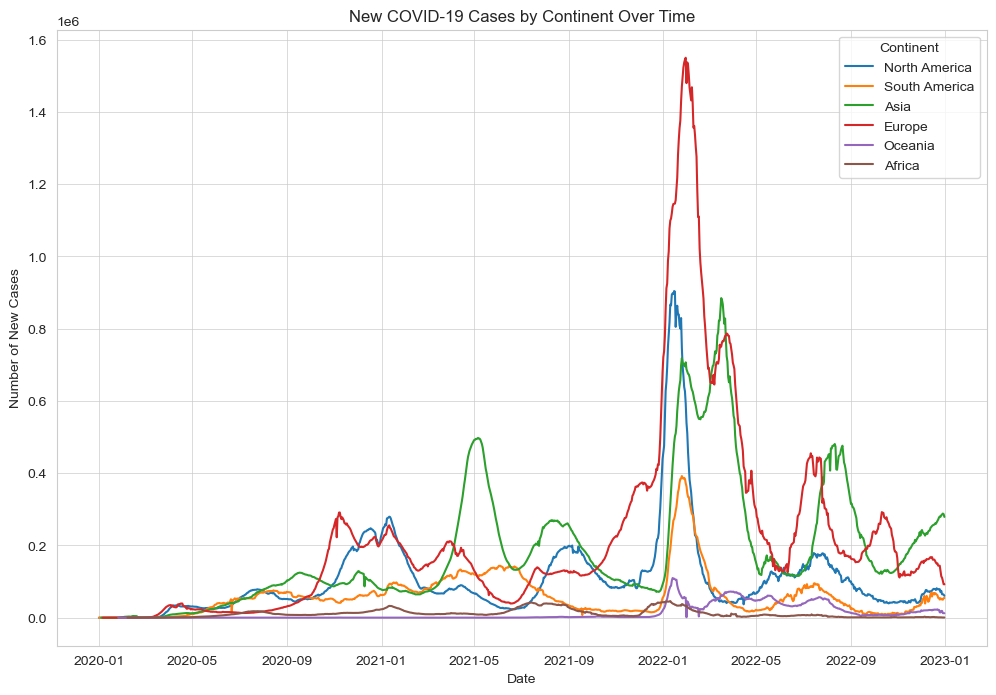

In [29]:
filtered_data = data[data['date'] < '2023-01-01']
grouped_data = filtered_data[~(filtered_data['continent']==0)].groupby(['date', 'continent'])['new_cases_smoothed'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='new_cases_smoothed', hue='continent', data=grouped_data)
plt.title('New COVID-19 Cases by Continent Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.legend(title='Continent')
plt.grid(True)  
#plt.savefig('../output/Introductory_Visualizations/Cases/newcasesbycontinent')

#### 1.3 Cases over time by continent in subplots

In [ ]:
grouped_data = data[~(data['continent']==0)].groupby(['continent','date'])['new_cases_smoothed'].sum().reset_index()
continents_of_interest=['North America','South America','Asia','Europe','Oceania','Africa']
fig, axs = plt.subplots(1,6,figsize=(24,8), sharey=True)
for i,continent in enumerate(continents_of_interest):
        sns.lineplot(x='date', y='new_cases_smoothed',  data=grouped_data[grouped_data['continent']==continent],ax=axs[i])
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('New Cases')
        axs[i].set_title(continent)
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].grid(True)
plt.suptitle('New Cases by Continent')
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinentsp')


#### 1.4 Total cases vs total cases per million by continent

In [ ]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_nozero=data[~(data['continent']==0)]
for i, variable in enumerate(cases):
        top_countries = data_nozero.groupby('continent')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Continent')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinent.png')

#### 1.5 Total cases vs total cases per million by country

In [ ]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_noowid=data[~data['iso_code'].str.startswith("OWID_")]
for i, variable in enumerate(cases):
        top_countries = data_noowid.groupby('iso_code')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Country')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycountry.png')

#### 1.6 Scatter plots with variables of interest to see correlation with total cases

In [ ]:
variables_of_interest = [
    'icu_patients_per_million', 'total_tests_per_thousand', 'total_vaccinations_per_hundred',
    'stringency_index', 'hospital_beds_per_thousand', 'aged_65_older'
]
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()
for i, variable in enumerate(variables_of_interest):
    sns.scatterplot(x=variable, y='total_cases_per_million', data=data, ax=axs[i], markers='.')
    axs[i].set_title(f'Total Cases per Million vs. {variable}')
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Total Cases per Million')
plt.tight_layout()
#plt.savefig('../output/Introductory_Visualizations/Cases/totcasescorr.png')

### 2. Deaths visualized

#### 2.1 New deaths

In [ ]:
daily_deaths = data.groupby('date')['new_deaths'].sum()
daily_deaths_smoothed = data.groupby('date')['new_deaths_smoothed'].sum()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,20))

ax1.plot(daily_deaths, label='New Deaths Per Day')
ax1.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax1.legend()

ax2.plot(daily_deaths_smoothed, label='New Deaths Per Day, Smoothed Data')
ax2.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax2.legend()

#plt.savefig("../output/Introductory_Visualizations/Deaths/new_deaths.png")

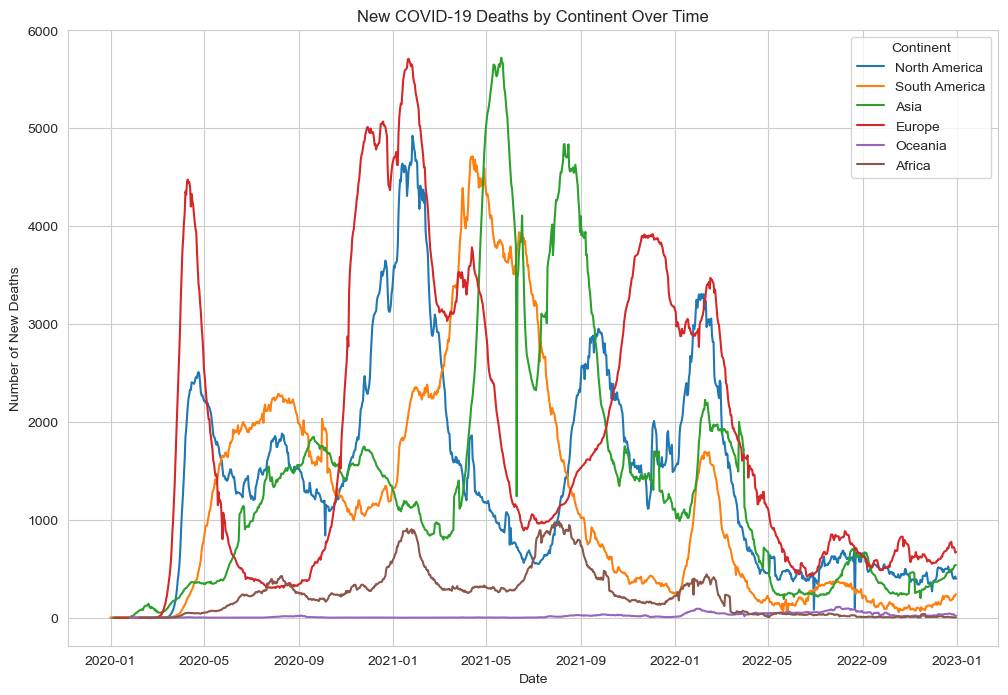

In [5]:
filtered_data = data[data['date'] < '2023-01-01']

grouped_data = filtered_data[~(filtered_data['continent']==0)].groupby(['date', 'continent'])['new_deaths_smoothed'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')

sns.lineplot(x='date', y='new_deaths_smoothed', hue='continent', data=grouped_data)
plt.title('New COVID-19 Deaths by Continent Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Deaths')
plt.legend(title='Continent')
plt.grid(True)
plt.savefig('../output/Introductory_Visualizations/Deaths/newdeathsbycontinent')

Trying to find out if there is a difference in deaths per million among the continents.

In [ ]:
new_deaths_per_million_continent = data.groupby(['date', 'continent'])['new_deaths_per_million'].sum().reset_index()
new_deaths_per_million_continent_smoothed = data.groupby(['date', 'continent'])['new_deaths_smoothed_per_million'].sum().reset_index()
total_cases_per_continent = data.groupby(['date', 'continent'])['total_cases_per_million'].sum().reset_index()
print(new_deaths_per_million_continent)
print(new_deaths_per_million_continent_smoothed)

#### 2.2 New deaths per million by continent

In [ ]:
continents_deaths = new_deaths_per_million_continent['continent'].unique()
#Creating suplots per Continent with the real counts
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)
# Iterate over each continent and create a subplot
for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent[new_deaths_per_million_continent['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillion_Subplots.png")


#### 2.3 Smoothed new deaths per million by continent

In [ ]:
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent_smoothed[new_deaths_per_million_continent_smoothed['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_smoothed_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillionSmoothed_Subplots.png")

#### 2.4 New deaths per million divided by total cases

Trying to make a statement about the severity by analyzing the new deaths per million divided by the total cases.
Merge the new deaths and total cases. Calculate new deaths per million divided by total cases per million.

In [ ]:
death_cases_merge = pd.merge(new_deaths_per_million_continent_smoothed, total_cases_per_continent, on=['date', 'continent'])
death_cases_merge['deaths_to_cases_ratio'] = death_cases_merge['new_deaths_smoothed_per_million'] / death_cases_merge['total_cases_per_million']


fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = death_cases_merge[death_cases_merge['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='deaths_to_cases_ratio', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million divided by Total Cases per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million / Total Cases per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsToCasesRatio_Subplots.png")

## 4 Missing Data Analysis


### Structure


1. Introductory remarks about OWID
2. Preparatory steps
3. First overview of missing data
4. Overview missing data "cases" and "deaths"
5. Total cases continent analysis
6. Factual accuracy
7. Country analysis


### 1. Introductory remarks about OWID

OWID itself states that it generally takes its data from 4 different sources:
1. Specialized institutes
2. Research articles
3. International Institutations or statistics agencies
4. Official data from government sources

More specifically, looking at the OWID COVID dataset online where all the sources are indicated, it can be seen that OWID takes most of the data directly from the WHO COVID dashboard and then completes it with other sources which is why this dataset can be expected to be quite complete. However, the following analysis is attempting to analyze how much data is missing from the dataset and what kind of data is missing. 

### 2. Preparatory steps

#### 2.1 Adjusting visualization settings

In [ ]:
# Define colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

In [ ]:
#adjusting the viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### 2.2 Data Cleaning


In [ ]:
#dropping duplicates
data = data.drop_duplicates()
#separating OWID from non_OWID data
data_without_OWID = data[~data['iso_code'].str.contains('OWID')]
data_OWID = data[data['iso_code'].str.contains('OWID')]

What OWID contains:

In [ ]:
grouped_OWID_loc = data_OWID.groupby("location")
loc_OWID = list(grouped_OWID_loc.groups.keys())
print(loc_OWID)

OWID contains a few extra metrics and countries/continents or composites of such.

### 3. First overview of missing data

#### 3.1 Entries with complete information

In [ ]:
#For how many entries do we have complete information?
(data.isna().sum(axis=1) == 0).sum()

#### 3.2 Missing values per column overall

In [ ]:
#missing values overall per column
total_missing = data.isnull().sum()
total_missing_percentage = (total_missing / len(data)) * 100
total_missing_sorted = total_missing.sort_values()
total_missing_percentage_sorted = total_missing_percentage.sort_values()

In [ ]:
#graphing the missing values per column
plt.figure(figsize=(6, 8))
fig_mv_variables = sns.barplot(
    x = total_missing_percentage_sorted.values,
    y = total_missing_percentage_sorted.index
)
fig_mv_variables.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")              

### 4. Overview missing data "cases" and "deaths"

#### 4.1 Selecting only the columns containing information about cases and deaths

In [ ]:
#selecting the columns about cases of interest
columns_about_cases = data.loc[:, data.columns.str.contains('cases')]
columns_about_cases.columns

In [ ]:
columns_about_deaths = data.loc[:, data.columns.str.contains('death')]
columns_about_deaths.columns

#### 4.2 Sorting and plotting overall missing data about cases

In [ ]:
def missing_data_filtered(columns_of_interest):
    total_missing = columns_of_interest.isnull().sum()
    total_missing_percentage = (total_missing / len(data)) * 100
    total_missing_sorted = total_missing.sort_values()
    total_missing_percentage_sorted = total_missing_percentage.sort_values()
    return total_missing_percentage_sorted

total_missing_percentage_deaths_sorted = missing_data_filtered(columns_about_deaths)

In [ ]:
plt.figure(figsize=(4, 3))
deaths_overview = sns.barplot(
    x = total_missing_percentage_deaths_sorted.values,
    y = total_missing_percentage_deaths_sorted.index
)
deaths_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/deathsmissing_data.png", bbox_inches="tight")  

#### 4.3 Sorting and plotting overall missing data about deaths

In [ ]:
total_missing_percentage_cases_sorted = missing_data_filtered(columns_about_cases)

In [ ]:
plt.figure(figsize=(4, 3))
cases_overview = sns.barplot(
    x = total_missing_percentage_cases_sorted.values,
    y = total_missing_percentage_cases_sorted.index
)
cases_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/casesmissing_data.png", bbox_inches="tight") 

There is in the overall dataset a lot more data around cases than deaths. However, amongst the columns that give information about either death or cases, the variability as to the amount of missing data is low.

### 5 Total cases continent analysis


#### 5.1 Amount of data per country

Comment: Since reporting is generally done on a national level, it makes sense to have a look at individual countries to find out where potential data is missing.

In [ ]:
#how many countries are we dealing with overall
unique_values_world = data_without_OWID['iso_code'].unique()
print (len(unique_values_world))

In [ ]:
#calculating the number of entries for each country
length_list = []
length_list_in_years = []

for i in range(len(unique_values_world)):
    country = unique_values_world[i]
    length_country = len(data_without_OWID.loc[df['iso_code'] == country])
    length_list.append(length_country)
    length_list_in_years.append(length_country/365)

sorted_country_length = sorted(length_list)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(length_list_in_years, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('data points converted to number of years')
plt.ylabel('number of countries')
plt.title("Number of entries in the data set per country")
plt.show()

#### 5.2 Total cases Asia


In [ ]:
#different continents
filtered_continents = data_without_OWID["continent"].unique()
filtered_continents

In [ ]:
#function returning list of all different countries on one continent
def countries_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['iso_code'].unique()
    return unique_values_continent

unique_values_Asia = countries_per_continent("Asia")
unique_values_Asia

In [ ]:
def continent_values(continent_uniq_val):
    values = []
    for i in range(len(continent_uniq_val)):
        currentcountry = continent_uniq_val[i]
        filtered_country = data.loc[df['iso_code'] == currentcountry]
        no_rows_current_country = len(filtered_country)
        missing = (filtered_country["total_cases"].isnull().sum())
        total_missing_percentage_current_country = (missing / len(filtered_country)) * 100
        values.append(total_missing_percentage_current_country)
    return values

values_Asia = continent_values(unique_values_Asia)

In [ ]:
def plotting_barplot_continent (unique_codes, values):
    plt.figure(figsize=(26, 8))
    missing_values_Asia = sns.barplot(
        x = unique_codes,
        y = values
    )

    deaths_overview.set(
        title="Missing values per variable",
        xlabel="Percentage of Missing Values",
        ylabel="Variables"
    )

    #plt.savefig("../output/Missing_Data_Analysis/casesmissing_data2.png", bbox_inches="tight") 

plotting_barplot_continent(unique_values_Asia, values_Asia)

#### 5.3 Total Cases Europe

In [ ]:
unique_values_Europe = countries_per_continent("Europe")
unique_values_Europe

In [ ]:
values_Europe = continent_values(unique_values_Europe)

In [ ]:
plotting_barplot_continent(unique_values_Europe, values_Europe)

#### 5.4 Total Cases Africa

In [ ]:
unique_values_Africa = countries_per_continent("Africa")
unique_values_Africa

In [ ]:
values_Africa = continent_values(unique_values_Africa)

In [ ]:
plotting_barplot_continent(unique_values_Africa, values_Africa)

#### 5.5 Total Cases North America

In [ ]:
unique_values_North_America = countries_per_continent("North America")
unique_values_North_America

In [ ]:
values_North_America = continent_values(unique_values_North_America)

In [ ]:
plotting_barplot_continent(unique_values_North_America, values_North_America)

### 6. Factual accuracy

#### 6.1 Do total cases and new cases lead to the same numbers?

Looking at Canada the reporting started on 23 of January but the first death was on March 9. A quick search on the internet confirms that 9 March was the date on which the frist Canadian person died. That makes 46 days on which there is no data on deaths. But there are 1132 entries for Canada and hence 46/1132 = 4%. In the case of Switzerland 10 no values for deaths and 1099 rows so that would make 1% of the data missing. For Germany 42/1128 = 4%. All of this data is not missing, it is just wrongly classified as NA when these should be zero.

In [ ]:
def comparison_total_new_cases(country): 
    filtered_country = data_without_OWID.loc[df["location"] == "Sweden"]
    filtered_country_total_cases_from_tc = filtered_country.iloc[-1, 4]
    print ("total cases from the total cases column: ", filtered_country_total_cases_from_tc)
    print ("total cases when summing over new cases: ", filtered_country["new_cases"].sum())

comparison_total_new_cases("Sweden")

#### 6.2 How accurate are vaccination statistics?

According to Wikipedia, the first vaccination in Switzerland, Germany and France tool place on December 23 2020, December 22, 2020 and December 17, 2020 respectively. The dataset confirms these:

In [ ]:
def first_vaccination_statistics_accuracy(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    first_vaccination_index = filtered_country["total_vaccinations"].first_valid_index()
    return filtered_country.iloc[first_vaccination_index,:5]
    
first_vaccination_statistics_accuracy("France")

### 7. Country analysis

#### 7.1 Function to replace missing data with zeros

In [ ]:
#here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    #filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals)


#### 7.2 Function for missing values excluding missing at the end and at the beginning for a specific country

In [ ]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [ ]:
filtering_missing_country("Finland")

#### 7.3 Function total diff for many countries

In [ ]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [ ]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries(list, dataframe):
    count = 0
    for i in (list):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

several_countries(unique_locations_Europe, empty_df)

In [ ]:
country_of_interest = "Finland"
filtered = data_without_OWID.loc[df['location'] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500)

Finland and other countries only reporting once per week

## 5 Handling of missing data

### Structure
1. Decision to delete columns 63:67
2. Decision to delete entire countries
3. Decision over keeping or deleting/imputing columns 0:16 (Nico)
4. Decision over keeping or deleting/imputing columns 16:32 (Leon)
5. Decision over keeping or deleting/imputing columns 32:48 (Florin)
6. Decision over keeping or deleting/imputing columns 48:63 (Sevi)
7. Actual imputations and deletions

### 1. Decision to delete columns 63:67

In [ ]:
missing_percentages = df.iloc[:,63:].isnull().sum() / df.shape[0] *100
print(missing_percentages)

More than 95% of entries are missing. These four columns will be deleted entirely

### 2. Decision to delete entire countries

#### 2.1 What countries miss how many rows entirely?

What countries are missing entire columns? Helps us determine if we should maybe just remove the countries instead of the columns

In [ ]:
result_data = []
for column in df.columns:
    grouped_by_iso = df.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all())
    result_data.extend([{'ISO_Code': iso_code, 'Column': column, 'All_NaN': all_nan} for iso_code, all_nan in zip(nan_counts.index, nan_counts.values)])

result_df = pd.DataFrame(result_data)
most_true_iso_code = result_df.loc[result_df['All_NaN']].groupby('ISO_Code').size().sort_values(ascending=False)

print("ISO code with the most occurrences of completely missing entire columns in their respective row:", most_true_iso_code)

OWID seems more and more useless. Maybe also delete other countries entirely.

Trying to find out where to make the cutoff point for the countries:

In [ ]:
top20_missing_complete_loc= most_true_iso_code.head(20)
plt.figure(figsize=(15,6))
plt.bar(top20_missing_complete_loc.index, top20_missing_complete_loc)
plt.xlabel("iso codes")
plt.ylabel("Number of completely missing columns")
plt.tight_layout()
plt.xticks(rotation=45)

This topic of row/country deletion has to be visited again after deleting columns that can be deleted for sure.

### 3. Decision over keeping or deleting/imputing columns 0:16 (Nico)

#### 3.1 Missing data percentages (Nico)

In [ ]:
columns_nico = data.columns[0:16]
missing_data_nico = df[columns_nico].isnull().sum() 
missing_data_nico_percentage = missing_data_nico / df.shape[0] * 100
print(missing_data_nico_percentage)

We can see that the first 4 columns are all (except continent) complete. This makes sense since they contain information about the country and date and did not have to be measured.
In general the amount of missing values is very low. For this reason and since cases and deaths are our Label, we cannot delete a column from this part. 

#### 3.2 Missing data per country

In the next step we will look if there are certain countries missing a huge amount of data. If that were the case we could delete the entries of those couuntries. To get an overview I created a plot for each continent containing all the countries and their respective missing entries in the first 16 columns.

In [ ]:
#print(pd.DataFrame(filtering_missing_country('Finland'))['# of missing entries'][0:16]) 
#print(locations_per_continent('Europe'))

def missingdata_country_nico(continent):
    missing_data_countrylist_nico = []
    
    for country in locations_per_continent(continent):
        missing_data_country_nico = pd.DataFrame(filtering_missing_country(country))
        sum_missing_entries_nico = missing_data_country_nico['# of missing entries'][0:16].sum()
        missing_data_countrylist_nico.append({'Country': country, 'Missing Entries': sum_missing_entries_nico})
        #print(f"{country}: {sum_missing_entries_nico}")
    missing_data_country_df_nico = pd.DataFrame(missing_data_countrylist_nico)
    
    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=missing_data_country_df_nico)
    plt.title('Missing Entries per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Number of Missing Entries')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_data-" + continent +".png"
    plt.savefig(safepoint)


#for continent in continents_of_interest:
    #missingdata_country_nico(continent)

It is clearly visible that there are a few outliers, which have a lot of missing data.

In the next part of the code I wanted to check if the 'per million' numbers are deducted from the total numbers. This was done with the total cases and toatal cases per million.

In [ ]:
for country in locations_per_continent('Europe'):
    country_entries_totalcases = df[df[columns_nico[2]] == country].iloc[:, 4]
    country_entries_totalcasesmillion = df[df[columns_nico[2]] == country].iloc[:, 10]
    country_entries_missing_totalcases = country_entries_totalcases.isnull().sum()
    country_entries_missing_totalcasesmillion = country_entries_totalcasesmillion.isnull().sum()
    print(country, country_entries_missing_totalcases, country_entries_missing_totalcasesmillion)

These results make sense and show that the 'per million' entries are probably deducted from the total numbers. This means the amount of missing entries per country is the same in those two columns. This means we only have to concentrate on the column total cases, to get a feedback on how many entries in general are missing.

Now we try to find out how many percentage of the data are missing in each country in the columns total cases and total deaths.

In [ ]:
def missingdata_cases_nico(continent):
    missing_data_caseslist_nico = []
    
    for country in locations_per_continent(continent):
        country_cases_nico = df[df[columns_nico[2]] == country].iloc[:, 4]
        country_casesmissing_nico = country_cases_nico.isnull().sum()
        country_casesmissing_nico_percentage = (country_casesmissing_nico / len(country_cases_nico)) * 100
        if country_casesmissing_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + country)
        missing_data_caseslist_nico.append({'Country': country, 'Missing Entries': country_casesmissing_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingcases_df_nico = pd.DataFrame(missing_data_caseslist_nico)
    #print(country_missingcases_df_nico)
    
    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingcases_df_nico)
    plt.title('Percentage of Missing Entries in Total Cases per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Percentage of Missing Entries in total cases')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totalcases-" + continent +".png"
    plt.savefig(safepoint)
    

#for continent in continents_of_interest:
    #missingdata_cases_nico(continent)

In all of these countries all entries in total cases are missing: Puerto Rico, Sint Maarten (Dutch part), United States Virgin Islands, Turkmenistan, Guernsey, Jersey, Western Sahara, Guam, Niue, Northern Mariana Islands, Pitcairn, Tokelau. I recommend to delete these countries.
Now we will have a look at the column total deaths:

In [ ]:
def missingdata_deaths_nico(continent):
    missing_data_deathslist_nico = []
    
    for country in locations_per_continent(continent):
        country_deaths_nico = df[df[columns_nico[2]] == country].iloc[:, 7]
        country_deathsmissing_nico = country_deaths_nico.isnull().sum()
        country_deathsmissing_nico_percentage = (country_deathsmissing_nico / len(country_deaths_nico)) * 100
        if country_deathsmissing_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + country)
        missing_data_deathslist_nico.append({'Country': country, 'Missing Entries': country_deathsmissing_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingdeaths_df_nico = pd.DataFrame(missing_data_deathslist_nico)
    #print(country_missingdeaths_df_nico)


    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingdeaths_df_nico)
    plt.title('Percentage of Missing Entries in Total Deaths per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Percentage of Missing Entries in total deaths')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totaldeaths-" + continent +".png"
    plt.savefig(safepoint)
    

#for continent in continents_of_interest:
    #missingdata_deaths_nico(continent)

Countries in which all the entries in the column total deaths are missing are: Puerto Rico,Sint Maarten (Dutch part),United States Virgin Islands, Turkmenistan, Falkland Islands, Guernsey, Jersey, Vatican, Saint Helena, Western Sahara, Guam, Niue, Northern Mariana Islands, Pitcairn, Tokelau, Tuvalu. 

These contain also all the countries which were missing all entries in the column total cases. My recommendation is to delete these countries from the dataset.

Finally we will have a look at the regions in the OWID part of the dataset:

In [ ]:
def missingdata_cases_nico_OWID():
    missing_data_caseslist_OWID_nico = []
    
    for location in loc_OWID:
        country_casesOWID_nico = df[df[columns_nico[2]] == location].iloc[:, 4]
        country_casesmissingOWID_nico = country_casesOWID_nico.isnull().sum()
        country_casesmissingOWID_nico_percentage = (country_casesmissingOWID_nico / len(country_casesOWID_nico)) * 100
        if country_casesmissingOWID_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + location)
        missing_data_caseslist_OWID_nico.append({'Country': location, 'Missing Entries': country_casesmissingOWID_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingcasesOWID_df_nico = pd.DataFrame(missing_data_caseslist_OWID_nico)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingcasesOWID_df_nico)
    plt.title('Percentage of Missing Entries in Total Cases per Location in OWID')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Location')
    plt.ylabel('Percentage of Missing Entries in total cases')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totalcases-OWID.png"
    plt.savefig(safepoint)
    

#missingdata_cases_nico_OWID()

In [ ]:
def missingdata_deaths_nico_OWID():
    missing_data_deathslist_OWID_nico = []
    
    for location in loc_OWID:
        country_deathsOWID_nico = df[df[columns_nico[2]] == location].iloc[:, 7]
        country_deathsmissingOWID_nico = country_deathsOWID_nico.isnull().sum()
        country_deathsmissingOWID_nico_percentage = (country_deathsmissingOWID_nico / len(country_deathsOWID_nico)) * 100
        if country_deathsmissingOWID_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + location)
        missing_data_deathslist_OWID_nico.append({'Country': location, 'Missing Entries': country_deathsmissingOWID_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingdeathsOWID_df_nico = pd.DataFrame(missing_data_deathslist_OWID_nico)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingdeathsOWID_df_nico)
    plt.title('Percentage of Missing Entries in Total Deaths per Location in OWID')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Location')
    plt.ylabel('Percentage of Missing Entries in total deaths')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totaldeaths-OWID.png"
    plt.savefig(safepoint)
    

#missingdata_deaths_nico_OWID()

Here we can see that the regions England, Northern Ireland, Northern Cyprus, Scotland and Wales are missing all datapoints. I recommend to delete these regions too.

### 4. Decision over keeping or deleting/imputing columns 16:32 (Leon)

#### 4.1 Missing data percentages (Leon)

In [ ]:
columns_leon = data.columns[16:32]
missing_percentages_leon = df[columns_leon].isnull().sum() / df.shape[0] *100
print(missing_percentages_leon)

At first glance it only makes sense to keep reproduction rate and maybe the ones with percentages of missing data below 75%

#### 4.2 Visualization of variables of Interest (Leon)

Visualizing all my variables for three countries to determine usefulness and worth of imputation.

In [ ]:
for column in columns_leon:    
    belgium_data = df.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column].fillna(0)

    brazil_data = df.groupby("iso_code").get_group("BRA")
    brazil = brazil_data[column].fillna(0)

    mexico_data = df.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column].fillna(0)

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(brazil_data["date"], brazil)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Brazil")

    axs[2].plot(mexico_data["date"], mexico)
    axs[2].set_xlabel("date")
    axs[2].set_ylabel(column)
    axs[2].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols16-32/missing_data-" + column +".png"
    #plt.savefig(safepoint)

Some of them seem to be imputable. We will keep all variables for the cases since we will target number of cases in our prediction. The ones that were missing 75% plus of their values are also the ones that look like they will not be imputable by any means. Brazil also seems to be lacking positive rate completely (which was under 75% missing values but not in the cases group). Positive rate and reproduction rate are the only ones left to determine whether we will keep them or delete them (The ones with 75% plus missing will most likely be deleted).

#### 4.3 How many countries are entirely missing my variables of interest? 

In [ ]:
all_countries = list(df.groupby("iso_code").groups.keys())
for column in columns_leon:
    grouped_by_iso = df.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

This again shows that the variables that miss more than 75% of their values are also very much the ones where the highest percentage of countries do not have any values of them stored at all. (90% means that 90 percent of all countries do not have a single value but Nan for this column)

If we want to keep all variables containing the tests, we would have to delete rows that contain only Nan for those columns. For what countries is that the case?

In [ ]:
test_variables = [var for var in columns_leon if 'test' in var]
empty_countries_test = []
for column in test_variables:  
    test_nan_countries = grouped_by_iso[column].apply(lambda x: x.isnull().all())
    test_nan_countries_true = test_nan_countries[test_nan_countries == True]
    empty_countries_test.append(test_nan_countries_true.index)
empty_countries_test


Now let's see what country is missing how many test variables:

In [ ]:
counter_dict = {}
for countries in empty_countries_test:
    for country in countries:
        existing_country = counter_dict.get(country)
        if existing_country is not None:
            counter_dict[country] += 1
        else:
            counter_dict[country] = 1
sorted_counter_dict = dict(sorted(counter_dict.items(), key=lambda item:item[1]))
print(sorted_counter_dict)
sorted_counter_dict.keys()


Countries missing all 6 columns:

In [ ]:
countries_without_tests = [key for key, value in counter_dict.items() if value == 6]
countries_without_tests

If we wanted to keep all test variables, we will have to delete all of those countries listed above. We will for sure delete the countries missing all 6 columns.

### 5. Decision over keeping or deleting/imputing columns 32:48 (Florin)

#### 5.1 Functions for analysis

##### 5.11 Function to replace missing data with zeros

In [ ]:
""" #here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals) """


##### 5.12 Function for missing values excluding missing at the end and at the beginning for a specific country

In [ ]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [ ]:
filtering_missing_country("Germany")

In [ ]:
data_countr = data_without_OWID.loc[df['location'] == "Germany"]
columns_to_print = ["location", "tests_per_case"]
data_countr = data_countr[columns_to_print]
data_countr.head(2000)

##### 5.13 Function total diff for many countries

In [ ]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [ ]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries_diff_overall_specific_columns(list_of_countries, empty_dataframe):
    count = 0
    for i in (list_of_countries):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

output = several_countries_diff_overall_specific_columns(unique_locations_Europe, empty_df)
output.iloc[list(range(2, 3)) + list(range(32, 48)),:]

In [ ]:
threshhold = 50
unique_locations_world = data_without_OWID['location'].unique()
empty_df = pd.DataFrame()
dataset = unique_locations_world

In [ ]:
def countries_to_check(column, threshhold_value):
    output = several_countries_diff_overall_specific_columns(dataset, empty_df)
    output_filter = output.loc[column] #filtering for the specific column that we are interested in
    output_filter = output_filter.to_frame()
    output_filter = output_filter.dropna(axis = 0)
    output_filter = output_filter[output_filter > threshhold_value]
    output_filter = output_filter.dropna(axis = 0)
    return output_filter

In [ ]:
def countries_eligible(column, threshhold_value):
    output = several_countries_diff_overall_specific_columns(dataset, empty_df)
    output_filter = output.loc[column] #filtering for the specific column that we are interested in
    output_filter = output_filter.to_frame()
    output_filter = output_filter.dropna(axis = 0)
    output_filter = output_filter[output_filter < threshhold_value]
    output_filter = output_filter.dropna(axis = 0)
    return output_filter

In [ ]:
data_countr = data_without_OWID.loc[df['location'] == "Germany"]
columns_to_print = ["date", "total_vaccinations"]
data_countr = data_countr[columns_to_print]
data_countr.head(2000)

##### 5.14 Function to check whether there is some pattern in how often the data is missing

In [ ]:
def regularity(country, column): #this function is to check how regular the reporting takes place
    data_countr = data_without_OWID.loc[df['location'] == country] #filtering the country of interest, including all columns
    data_countr = data_countr[column] #+filtering the column of interest for the country of interest
    data_countr = data_countr.reset_index(drop=True) #resetting the index to 0
    data_countr = data_countr.to_frame() #converting it to a pandas dataframe
    first_valid_index = data_countr.apply(lambda x: x.first_valid_index()) #finding the first valid index
    first_valid_index = first_valid_index[0] #isolating just the index number
    last_valid_index = data_countr.apply(lambda x: x.last_valid_index()) #finding the last valid index
    last_valid_index = last_valid_index[0] #isolating the last valid index number
    data_countr_filtered = data_countr.iloc[first_valid_index:last_valid_index, :] #filtering the data so we disregard the first values where we have no value and the last values
    data_countr_filtered = data_countr_filtered.isna().sum(axis=1) #1 where there is no data and zero where there is data
    data_countr_filtered = data_countr_filtered.replace({0: 1, 1: 0})
    return data_countr_filtered

#regularity("Germany", "total_vaccinations")

##### 5.15 Function to transform the dataset of regularity before plotting

In [ ]:
plt.figure(figsize=(8, 4))
plotting_values = np.array([1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0])
Brazil_data = regularity("Brazil", "total_vaccinations")
Brazil_data = Brazil_data.values

def transform(plotting_values):
    count_month = 2
    counter = 0
    for i in range(len(plotting_values)):
        counter += 1
        if plotting_values[i] == 1:
            plotting_values[i] = count_month
        #print (plotting_values[i])
        if counter == 30:
            counter = 0
            count_month += 1
            #print ("printing : ", count_month)
    return plotting_values

transform(plotting_values)

##### 5.16 Function to plot these patterns

In [ ]:
neue_liste = ["Armenia", "Albania", "Bahamas", "Brazil", "Germany", "France", "Argentina", "Bolivia"]
from IPython.display import display, HTML

def plotting_regularity(neue_liste): #this function is to plot the regularity graph
    num_plots = len(neue_liste)
    num_cols = 3  # Number of rows
    num_rows = (num_plots // num_cols) + 1
    fig_width = 6 * num_cols
    fig_height = 2 * num_plots
    j = 0
    k = 0
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height)) #creating as many subplots as the list is long
    for i, dataset in enumerate(neue_liste): #iterating over the list
        #print ("printing i: ", i, "and j and k", j, k )
        filtered_data_new = regularity(neue_liste[i], "total_vaccinations") #calling the regularity function to get the data
        filtered_data_new = filtered_data_new.values #converting the datatype
        filtered_data_new = transform(filtered_data_new)
        filtered_data_new = filtered_data_new[filtered_data_new != 0]
        axs[j,k].hist(filtered_data_new, bins=50, edgecolor='black')  # Plot histogram
        axs[j,k].set_title(neue_liste[i])  # Add title
        axs[j,k].set_xlabel('Index')  # Add x-axis label
        axs[j,k].set_ylabel('Number of entries')  # Add y-axis label
        axs[j,k].grid(True)
        if k == num_cols - 1:
            k = 0
            j += 1
        else: 
            k += 1
    plt.tight_layout()  # Adjust layout
    #display(HTML("<style> .output { overflow-y: auto; max-height: 200px; } </style>"))
    plt.show()  # Show the plot  

plotting_regularity(neue_liste)

#### 5.2 Individual column analysis

##### 5.2.1 Analysis "stringency index" (complete set)

In [ ]:
""" ## Analysis "stringency_index"
countries_eligible_stringency_index = countries_eligible("stringency_index", 50)
countries_to_check_stringency_index = countries_to_check("stringency_index", 50)
index_list_to_check_stringency_index = countries_to_check_stringency_index.index.tolist()
index_list_eligible_stringency_index = countries_eligible_stringency_index.index.tolist()
#index_list_to_check_stringency_index """

In [ ]:
""" data_stringency_index = data["stringency_index"]
data_stringency_index.head(2000) """

In [ ]:
""" plotting_regularity(index_list_eligible_stringency_index) """

##### 5.2.2 Analysis "new_people_vaccinated_smoothed_per_hundred" (complete set)


In [ ]:
""" ## Analysis "new_people_vaccinated_smoothed_per_hundred"
countries_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible("new_people_vaccinated_smoothed_per_hundred", 50)
countries_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check("new_people_vaccinated_smoothed_per_hundred", 50)
index_list_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check_new_people_vaccinated_smoothed_per_hundred.index.tolist()
index_list_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible_new_people_vaccinated_smoothed_per_hundred.index.tolist()
#index_list_to_check_new_people_vaccinated_smoothed_per_hundred """

##### 5.2.3 Analysis new_people_vaccinated_smoothed (complete set)

In [ ]:
## Analysis "new_people_vaccinated_smoothed"
countries_eligible_new_people_vaccinated_smoothed = countries_eligible("new_people_vaccinated_smoothed", 50)
countries_to_check_new_people_vaccinated_smoothed = countries_to_check("new_people_vaccinated_smoothed", 50)
index_list_to_check_new_people_vaccinated_smoothed = countries_to_check_new_people_vaccinated_smoothed.index.tolist()
index_list_eligible_new_people_vaccinated_smoothed = countries_eligible_new_people_vaccinated_smoothed.index.tolist()
#index_list_to_check_new_people_vaccinated_smoothed

##### 5.2.4 Analysis new_vaccinations_smoothed_per_million (complete set)

In [ ]:
""" ## Analysis "new_vaccinations_smoothed_per_million"
countries_eligible_new_vaccinations_smoothed_per_million = countries_eligible("new_vaccinations_smoothed_per_million", 50)
countries_to_check_new_vaccinations_smoothed_per_million = countries_to_check("new_vaccinations_smoothed_per_million", 50)
index_list_to_check_new_vaccinations_smoothed_per_million = countries_to_check_new_vaccinations_smoothed_per_million.index.tolist()
index_list_eligible_new_vaccinations_smoothed_per_million = countries_eligible_new_vaccinations_smoothed_per_million.index.tolist()
#index_list_to_check_new_vaccinations_smoothed_per_million """

##### 5.2.5 Analysis "total_boosters_per_hundred"

Summary: dropping Algeria, Niue, Tokelau

In [ ]:
""" ## Analysis "total_boosters_per_hundred"
countries_eligible_total_boosters_per_hundred = countries_eligible("total_boosters_per_hundred", 50)
countries_to_check_total_boosters_per_hundred = countries_to_check("total_boosters_per_hundred", 50)
index_list_to_check_total_boosters_per_hundred = countries_to_check_total_boosters_per_hundred.index.tolist()
index_list_eligible_total_boosters_per_hundred = countries_eligible_total_boosters_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_total_boosters_per_hundred) """



##### 5.2.6 Analysis people_fully_vaccinated_per_hundred	

Summary: Algeria, Nauru, Bonnaire, Pitcern, Niue, Tokelau, Turkmenistan

In [ ]:
""" ## Analysis "people_fully_vaccinated_per_hundred"
countries_eligible_people_fully_vaccinated_per_hundred = countries_eligible("people_fully_vaccinated_per_hundred", 50)
countries_to_check_people_fully_vaccinated_per_hundred = countries_to_check("people_fully_vaccinated_per_hundred", 50)
index_list_to_check_people_fully_vaccinated_per_hundred = countries_to_check_people_fully_vaccinated_per_hundred.index.tolist()
index_list_eligible_people_fully_vaccinated_per_hundred = countries_eligible_people_fully_vaccinated_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_people_fully_vaccinated_per_hundred) """

##### 5.2.7 Analysis "people_vaccinated_per_hundred"

Summary: dropping Algeria, Bonnaire, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan

In [ ]:
""" ## Analysis "people_vaccinated_per_hundred"
countries_eligible_people_vaccinated_per_hundred = countries_eligible("people_vaccinated_per_hundred", 50)
countries_to_check_people_vaccinated_per_hundred = countries_to_check("people_vaccinated_per_hundred", 50)
index_list_to_check_people_vaccinated_per_hundred = countries_to_check_people_vaccinated_per_hundred.index.tolist()
index_list_eligible_people_vaccinated_per_hundred = countries_eligible_people_vaccinated_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_people_vaccinated_per_hundred) """

##### 5.2.8 Analysis "total_vaccinations_per_hundred"

Summary: dropping Sint, Falkland islands, Pitcern, Niue, St Helena, Turkmenistan

In [ ]:
""" ## Analysis "total_vaccinations_per_hundred"
countries_eligible_total_vaccinations_per_hundred = countries_eligible("total_vaccinations_per_hundred", 50)
countries_to_check_total_vaccinations_per_hundred = countries_to_check("total_vaccinations_per_hundred", 50)
index_list_to_check_total_vaccinations_per_hundred = countries_to_check_total_vaccinations_per_hundred.index.tolist()
index_list_eligible_total_vaccinations_per_hundred = countries_eligible_total_vaccinations_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_total_vaccinations_per_hundred) """

##### 5.2.9 Analysis "new_vaccinations_smoothed" (complete set)

In [ ]:
""" ## Analysis "new_vaccinations_smoothed"
countries_eligible_new_vaccinations_smoothed = countries_eligible("new_vaccinations_smoothed", 50)
countries_to_check_new_vaccinations_smoothed = countries_to_check("new_vaccinations_smoothed", 50)
index_list_to_check_new_vaccinations_smoothed = countries_to_check_new_vaccinations_smoothed.index.tolist()
index_list_eligible_new_vaccinations_smoothed = countries_eligible_new_vaccinations_smoothed.index.tolist()
#index_list_to_check_new_vaccinations_smoothed """


##### 5.2.10 Analysis "new_vaccinations"


Summary: no countries to be dropped

In [ ]:
""" countries_eligible_new_vaccinations = countries_eligible("new_vaccinations", 50)
countries_to_check_new_vaccinations = countries_to_check("new_vaccinations", 50)
index_list_to_check_new_vaccinations = countries_to_check_new_vaccinations.index.tolist()
index_list_eligible_new_vaccinations = countries_eligible_new_vaccinations.index.tolist()
#plotting_regularity(index_list_to_check_new_vaccinations) """

##### 5.2.11 Analysis "total boosters"

Summary: dropping Niue

In [ ]:
""" ## Analysis "total_boosters"
countries_eligible_total_boosters = countries_eligible("total_boosters", 50)
countries_to_check_total_boosters = countries_to_check("total_boosters", 50)
index_list_to_check_total_boosters = countries_to_check_total_boosters.index.tolist()
index_list_eligible_total_boosters = countries_eligible_total_boosters.index.tolist()
#plotting_regularity(index_list_eligible_total_boosters) """

In [ ]:
""" data_boosters = data[["location", "total_boosters"]]
data_boosters.head(2000) """

##### 5.2.12 Analysis "people_fully_vaccinated"

Summary: dropping Algeria, Bonnaire, Niue, Pitcern, Turkmenistan

In [ ]:
""" ### Analysis "people_fully_vaccinated"
countries_eligible_people_fully_vaccinated = countries_eligible("people_fully_vaccinated", 50)
countries_to_check_people_fully_vaccinated = countries_to_check("people_fully_vaccinated", 50)
index_list_to_check_people_fully_vaccinated = countries_to_check_people_fully_vaccinated.index.tolist()
index_list_eligible_people_fully_vaccinated = countries_eligible_people_fully_vaccinated.index.tolist()
#plotting_regularity(index_list_to_check_people_fully_vaccinated) """

##### 5.2.13 Analysis "people_vaccinated"

Summary: dropping Sint, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan, Tuvalu

In [ ]:
""" ### Analysis "people_vaccinated"
countries_eligible_people_vaccinated = countries_eligible("people_vaccinated", 50)
countries_to_check_people_vaccinated = countries_to_check("people_vaccinated", 50)
index_list_to_check_people_vaccinated = countries_to_check_people_vaccinated.index.tolist()
index_list_eligible_people_vaccinated = countries_eligible_people_vaccinated.index.tolist()
#plotting_regularity(index_list_to_check_people_vaccinated) """

##### 5.2.14 Analysis "total_vaccinations"

Summary: dropping Bonnaire Sint, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan

In [ ]:
""" countries_eligible_total_vaccinations = countries_eligible("total_vaccinations", 50)
countries_to_check_total_vaccinations = countries_to_check("total_vaccinations", 50)
index_list_to_check_total_vaccinations = countries_to_check_total_vaccinations.index.tolist()
index_list_eligible_total_vaccinations = countries_eligible_total_vaccinations.index.tolist()
#plotting_regularity(index_list_to_check_total_vaccinations) """

##### 5.2.15 Analysis "tests_units"

Summary: dropping this entire column

In [ ]:
#useless column as this is only stating "tests performed" or "NaN"

##### 5.2.16 Analysis "tests per case"

Summary: dropping Cameroon, Curacao and Suriname from the dataset

In [ ]:
""" countries_eligible_tests_per_case = countries_eligible("tests_per_case", 50)
countries_to_check_tests_per_case = countries_to_check("tests_per_case", 50)
#countries missing completely at random but could be included: Bhutan, Botswana, El Salvador, Libya, Nepal, Palestine, United States Virgin Islands
#too many values generally missing: Cameroon, Curacao, Suriname
#weekly reporting: Germany
#monthly reporting: Hong Kong
#repeating values: Ireland
countries_to_check_tests_per_case """

Results from the analysis above:
1. Vatican needs to be removed

countries with complete information in all categories: [Austria, Belgium, Czechia, Denmark, Estonia, France, Italy, Latvia, Norway, Switzerland, Ukraine, United Kingdom, 	]


In [ ]:
EU_tests_per_case_every_value = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Faeroe Islands', 'Finland',
       'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Hungary',
       'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
       'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom', 'Vatican']


total_vaccinations_countries with almost no missing data = []
total_vaccinations_ountries_weekly_reporting = []
total_vaccinations_countries_random_missing_data = []

In [ ]:
""" country_of_interest = "Finland"
filtered = data_without_OWID.loc[df["location"] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500) """

In [ ]:
""" country_name = "Finland"
data_with_all_rows = filtering_missing_country(country_name)
data_with_specific_rows = data_with_all_rows.iloc[list(range(2, 3)) + list(range(32, 48)),:]
data_with_specific_rows """

### 6. Decision over keeping or deleting/imputing columns 48:63 (Sevi)

#### 6.1 Rough overview over the percentages of missing values:

In [ ]:
columns_sevi = data.columns[48:63]
missing_percentages_sevi = df[columns_sevi].isnull().sum() / df.shape[0] *100
print(missing_percentages_sevi.sort_values(ascending=False))

All  <75% that was previously defined -> no complete deletions

7 columns are  <75% and >20% -> further investigation

8 columns are <20% -> keep as is

#### 6.2 Static Values

I first tried to analyze the change of the missing values over for a few countries.

In [ ]:
for column in columns_sevi:    
    belgium_data = df.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column].fillna(0)

    brazil_data = df.groupby("iso_code").get_group("BRA")
    brazil = brazil_data[column].fillna(0)

    mexico_data = df.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column].fillna(0)

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(brazil_data["date"], brazil)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Brazil")

    axs[2].plot(mexico_data["date"], mexico)
    axs[2].set_xlabel("date")
    axs[2].set_ylabel(column)
    axs[2].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols48-63/missing_data-" + column +".png"
    #plt.savefig(safepoint)

None of the number of values change over time.

There is only one value for each country for the whole dataset.

This may complicate any impution attempts

Here a function to confirm this finding:

In [ ]:
def check_constant_values(data, country_col, time_col, variables):
    results = {}
    for country in data[country_col].unique():
        country_data = data[data[country_col] == country]
        results[country] = {}
        for variable in variables:
            unique_values = country_data[variable].dropna().unique()
            results[country][variable] = len(unique_values) < 2
    return results

constant_value_check = check_constant_values(data_without_OWID, 'iso_code', 'date', columns_sevi)

for country, variables in constant_value_check.items():
    print(f"Country: {country}")
    for var, is_constant in variables.items():
        if is_constant == False:
            print(f"  {var}: varies")
    print("\n")



### 7. Actual imputations and deletions

#### 7.1 First deletions that can already be made

In [ ]:
#More than 90% of entries are missing for those four variables:
data_clean = data.drop(["excess_mortality_cumulative_absolute", "excess_mortality_cumulative", "excess_mortality", "excess_mortality_cumulative_per_million"], axis=1, inplace=False)


#Country deletions (Needed to clean up Leon data): They miss all 6 test columns, we want to have at least one tests column for our algorithms:
data_clean = data_clean[~data_clean['iso_code'].isin(countries_without_tests)]


#Leons deletions of columns missing more than 75% of data overall and also over 80% of all countries miss those variables entirely :
data_clean = data_clean.drop(['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 
                              'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million'],axis=1, inplace=False)

#Florin deletions of additional columns :
data_clean = data_clean.drop(['tests_units'],axis=1, inplace=False)

#Florin country deletions:
countries_to_be_deleted_Florin = ["Algeria", "Bonaire Sint Eustatius and Saba", "Falkland Islands", "Nauru", "Niue", "Pitcairn", "Saint Helena", "Tokelau", "Turkmenistan","Tuvalu", "Vatican"]
data_clean = data_clean[~data_clean['location'].isin(countries_to_be_deleted_Florin)]


#insert all your drops and imputations here and save in data_clean!
#Von jetzt an nur noch data_clean brauchen






# TO REMOVE ASWELL: ALL OWID (we already have created data frames that dont include OWID)
data_clean = data_clean[~data_clean['iso_code'].str.contains('OWID')]


print("Clean data columns left:", data_clean.columns.to_list())
print("Clean data countries left:", data_clean["iso_code"].unique())
###

#### 7.2 Data observation after first deletions and further deletions (Leons Columns, countries):

Using this to see how our data_clean behaves after certain removals:

In [ ]:
leon_columns_after_first_clean = ["reproduction_rate", "total_tests", "new_tests", "total_tests_per_thousand", 
                                  "new_tests_per_thousand", "new_tests_smoothed", 
                                  "new_tests_smoothed_per_thousand", "positive_rate"]

all_countries = list(data_clean.groupby("iso_code").groups.keys())
for column in leon_columns_after_first_clean:
    grouped_by_iso = data_clean.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

We still have 19% of the countries that are entirely missing new_tests and new_tests per thousand. Those will need to be removed, after that we still have 4 variables that contain information about tests, which should be enough.

In [ ]:
data_clean = data_clean.drop(["new_tests", "new_tests_per_thousand"],axis=1, inplace=False)

Observing what countries are still missing positive_rate:

In [ ]:
empty_countries_p_rate = []
p_rate_loc = grouped_by_iso["positive_rate"].apply(lambda x: x.isnull().all())
p_rate_nan_countries_true = p_rate_loc[p_rate_loc == True]
empty_countries_p_rate.append(p_rate_nan_countries_true.index)

Deleting those countries:

In [ ]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_p_rate[0].tolist())]

Observing what countries are still missing total_tests_per_thousand: 

In [ ]:
empty_countries_ttt = []
ttt_loc = grouped_by_iso["total_tests_per_thousand"].apply(lambda x: x.isnull().all())
ttt_nan_countries_true = ttt_loc[ttt_loc == True]
empty_countries_ttt.append(ttt_nan_countries_true.index)


Deleting those countries:

In [ ]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_ttt[0].tolist())]

Observing what countries are still missing reproduction_rate: (Also heavily affects Nicos data)

In [ ]:
empty_countries_r_rate = []
r_rate_loc = grouped_by_iso["reproduction_rate"].apply(lambda x: x.isnull().all())
r_rate_nan_countries_true = r_rate_loc[r_rate_loc == True]
empty_countries_r_rate.append(r_rate_nan_countries_true.index)

Deleting those countries:

In [ ]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_r_rate[0].tolist())]

Observation after further deletions:

In [ ]:
all_countries = list(data_clean.groupby("iso_code").groups.keys())
for column in data_clean.columns:
    grouped_by_iso = data_clean.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

What countries are left after deletions (Leon):

In [ ]:
countries_left = data_clean.groupby("iso_code").groups.keys()
print(countries_left)
print(len(countries_left))

My remaining six columns have no more completely empty rows. Now on to the imputation of those columns:

#### 7.3 Imputations of remaining six columns (Leon):

To impute (Leon): reproduction_rate, total_tests, total_tests_per_thousand, new_tests_smoothed, new_tests_smoothed_per_thousand, positive_rate

The missing data percentages for the columns are as follows:

In [ ]:
leon_columns_after_second_clean =["reproduction_rate", "total_tests", "total_tests_per_thousand", 
                                  "new_tests_smoothed", 
                                  "new_tests_smoothed_per_thousand", "positive_rate"]
missing_percentages_leon_after_del = data_clean[leon_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_leon_after_del)

This may seem like a lot for the latter 5 but if we consider that those columns have a lot of those entries missing at the start or the end they are easily imputable. They miss at start and end because countries either have not tracked them from the beginning or have stopped tracking after a certain time. 

Imputation: 

In [ ]:
data_clean = data_clean.interpolate(method='linear', subset=leon_columns_after_second_clean)
knn_imputer = KNNImputer(n_neighbors=5)
data_clean[leon_columns_after_second_clean] = knn_imputer.fit_transform(data_clean[leon_columns_after_second_clean])

I had to first do linear imputations for the end and start parts. There was still missing data after that, thats why there is also the knn imputation.

Taking a look at how imputation went:

In [ ]:
missing_percentages_leon_after_imp = data_clean[leon_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_leon_after_imp)

Those columns have no more missing data.

Also visually:

In [ ]:
for column in leon_columns_after_second_clean:    
    belgium_data = data_clean.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column]

    mexico_data = data_clean.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column]

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(mexico_data["date"], mexico)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols16-32/missing_data-" + column +"-after_imputation.png"
    #plt.savefig(safepoint)

#### 7.4 Imputations of columns (Sevi):

KNN Imputation

-KNN imputation works well for all seven variables, because they are all descriptive variables for a country's socioeconomic state.

-It identifies similarities based on multiple factors like health, economy, and demographics, ensuring the imputed values fit well with existing data.

In [ ]:

knn_imputer = KNNImputer(n_neighbors=5)
variables_to_impute = ['handwashing_facilities', 'extreme_poverty', 'male_smokers', 
                       'female_smokers', 'hospital_beds_per_thousand', 'human_development_index',
                       'aged_65_older']
data_clean[variables_to_impute] = knn_imputer.fit_transform(data_clean[variables_to_impute])



#### 7.5 Imputations of columns (Nico)

Getting an overview over the missing data after the first deletions

In [ ]:
nico_columns_after_second_clean = data_clean.columns[4:16] #in the first four columns we do not have to impute anything
missing_percentages_nico_after_del = data_clean[nico_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_nico_after_del)

There is only very little missing data left. All the columns are missing less than 1% which means a simple imputation method like forward/backward fill or mean imputation are sufficient for these columns. In this case we use forward and then backward fill to get rid of all NAN values. This makes sense since most NAN values are at the end or in the beginning of the recording period. The mean value would make less sense because of that

In [ ]:
data_clean[nico_columns_after_second_clean] = data_clean[nico_columns_after_second_clean].ffill().bfill() #using forward fill and then backward fill so that no nan are left
missing_percentages_nico_after_ffill = data_clean[nico_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_nico_after_ffill) #checking for missing values

To check that there are no more missing values and to check if the imputations make sense, here are two visual representation of the columns from two different countries:

In [ ]:
for column in nico_columns_after_second_clean:    
    finland_data_nico = data_clean.groupby("iso_code").get_group("FIN")
    finland_nico = finland_data_nico[column]

    mexico_data_nico = data_clean.groupby("iso_code").get_group("MEX")
    mexico_nico = mexico_data_nico[column]

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    # Plot data on each subplot
    axs[0].plot(finland_data_nico["date"], finland_nico)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Finland")

    axs[1].plot(mexico_data_nico["date"], mexico_nico)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_data-" + column +"-after_imputation.png"
    #plt.savefig(safepoint)

#### 7.6 Imupations of columns Forin:

In [ ]:
#KNN imputations
florin_columns_after_cleaning = ['tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index']
data_clean = data_clean.interpolate(method='linear', subset=florin_columns_after_cleaning)
knn_imputer = KNNImputer(n_neighbors=5)
data_clean[florin_columns_after_cleaning] = knn_imputer.fit_transform(data_clean[florin_columns_after_cleaning])


In [ ]:
#checking how many missing values are left
florin_columns_missing_percentages = data_clean[florin_columns_after_cleaning].isnull().sum() / data_clean.shape[0] *100
print(florin_columns_missing_percentages)

#### 7.7 Clean data overview after imputations

Missing percentages:

In [ ]:
missing_percentages_after_del_imp = data_clean.isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_after_del_imp)

In [ ]:
data_clean.info()

In [ ]:
data_clean.describe()

In [ ]:
data_clean.shape

## 6 Data preprocessing (Handling of missing data excluded) 

### Structure
1. Looking for outliers
2. Distribution of data
3. Splitting the data
4. Scaling

### 1. Looking for outliers

#### 1.1 Looking for outliers using IQR

In [ ]:
"""
summary_stats = data_clean.describe()
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1
# Define outliers using IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Align DataFrame columns with summary statistics columns
data_clean, lower_bound = data_clean.align(lower_bound, axis=1, join='inner')
data_clean, upper_bound = data_clean.align(upper_bound, axis=1, join='inner')
outliers = data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)].dropna(axis=1, how='all')
if not outliers.empty:
    print("Outliers:")
    print(outliers)
else:
    print("No outliers found.")
"""

#### 1.2 Looking for outliers using the Z-Score

In [ ]:
"""
z_scores = (data_clean - data_clean.mean()) / data_clean.std()
outlier_threshold = 3
outliers_zscore = (z_scores > outlier_threshold) | (z_scores < -outlier_threshold)

outliers_rows = outliers_zscore.any(axis=1)  # Rows containing at least one outlier
outliers_cols = outliers_zscore.sum(axis=0) # Amount of outliers per column

print(outliers_cols)
"""

### 2. Distribution of data 

#### 2.1 Distribution of numercial data

Testing whether the data is normally distributed or not:
Using the anderson darling test, since the shapiro wilks is not suitable for data n > 5000 

In [ ]:
num_data_clean = data_clean.select_dtypes(include='number')
distribution_results = {}
for column in num_data_clean.columns:
    result = sts.anderson(num_data_clean[column].dropna(), dist='norm')  ############################### I had to drop all na for it to work!!! -> maybe imputation needed
    test_stat = result.statistic 
    critical_val = result.critical_values
    #print(critical_val)                                
    #print(test_stat)                           
    if test_stat > critical_val[2]:
        result = "not normal"
    else:
        result = "normal"    
    distribution_results[column] = result


not_normal = []
for key, value in distribution_results.items():
    if value == "not normal":
        not_normal.append(key)
if len(not_normal) == 0:
    print("All numerical data seems to be normally distributed.")
elif len(not_normal) == len(num_data_clean.columns):
    print("No variable is normally distributed.")
else:
    print("All data but", not_normal, "seems to be normally distributed")

#### Distribution of numercial data visually

In [ ]:
columns_per_row = 3
num_columns = len(num_data_clean.columns)
num_rows = (num_columns - 1) // columns_per_row + 1
fig_width = 6 * columns_per_row
fig_height = 4 * num_rows
fig, axs = plt.subplots(num_rows, 4, figsize=(fig_width, fig_height))
axs = axs.flatten()
for i, column in enumerate(num_data_clean.columns):
    ax = axs[i]
    ax.hist(num_data_clean[column], bins=35, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
#plt.savefig("../output/Preprocessing/Distributions/distributions_of_variables.png")

### 3. Splitting the data

#### 3.1 Introduction to the split

We want to do a cross validation for multiple time frames of our data. Normal cross validation could lead to data leakage because it takes into account future data to predict past data. Time Series Split makes more sense to me. It works as follows:

Walk-forward validation is similar to time series cross-validation but focuses on predicting one step ahead using all available past data.

**Example:**

*First Fold:*

- Training: January to March

- Validation: April

*Second Fold:*

- Training: January to April

- Validation: May

*Third Fold:*

- Training: January to May

- Validation: June

Trying to find out how many folds to make:

In [ ]:
first_day = data_clean["date"].min()
last_day = data_clean["date"].max()
print("Data ranges from", first_day, "to", last_day)

#### 3.2 Splitting the data

Finding out when countries have their first entry:

In [ ]:
earliest_dates = data_clean.groupby('iso_code')['date'].min().reset_index()
print(earliest_dates.sort_values(by = "date"))

Splitting the data and saving the splits in a list. I went for a split of the data so that we have train dates for a length of four months and then one test month. This makes it an 80/20 split. 

In [ ]:
data_clean_sorted = data_clean.sort_values(by=['date'])
all_dates = pd.Series(data_clean_sorted["date"].unique()[150:]) #starting only from the 150th day in, since many countries started having entries only then
def custom_time_series_split(all_dates, train_window, test_window):
    splits = []
    # Iterate over the DataFrame to create train/test splits
    for i in range(0, len(all_dates), train_window + test_window):
        # Check if there are enough rows remaining for both training and testing data
        if i + train_window + test_window <= len(all_dates):
            # Training data
            train_data = all_dates.iloc[i:i+train_window]

            # Testing data
            test_data = all_dates.iloc[i+train_window:i+train_window+test_window]

            # Store the splits
            splits.append((train_data, test_data))

    return splits

# Create the split
splits = custom_time_series_split(all_dates, 120, 30)


for i, (train_data, test_data) in enumerate(splits):
    print(f"Split {i+1} - Train Data:")
    print(train_data.iloc[0])
    print(train_data.iloc[-1])
    print(f"\nSplit {i+1} - Test Data:")
    print(test_data.iloc[0])
    print(test_data.iloc[-1])
    print("\n----------------------------------------\n")



This creates 6 splits. As one can see, all of 2023 is not included which makes sense, since at the end we had to do most imputations and thus this will be more accurate.

Splitting the whole data accordingly:

In [ ]:
train_data_list = []
test_data_list = []

# Iterate over each split
for i, (train_dates, test_dates) in enumerate(splits):
    # Filter the original DataFrame based on the train and test dates
    train_data = data_clean[data_clean['date'].isin(train_dates)]
    test_data = data_clean[data_clean['date'].isin(test_dates)]
    
    # Append train and test dataframes to respective lists
    train_data_list.append(train_data)
    test_data_list.append(test_data)


for i in range(len(train_data_list)):
    print("Split:", i+1, ":")
    print("Train Data:")
    print(train_data_list[i].head())  
    print("\nTest Data:")
    print(test_data_list[i].head()) 
    print("------------------------------------------------------------------------------------------------------------------------")


This now gives us two lists with data frames in them. train_data_list has the seven data frames with the training data and test_data_list contain the six data frames where we can use our models. 

### 4. Scaling

#### 3.1 Finding numerical features

Removing the first 4 columns. Checking for non numeric features in the rest of the columns and deleting those to perform Normalization and Standardization:

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#figuring out the numerical features which have to be scaled... Removing the first 4 columns
numerical_features = data_clean.columns[4:len(data_clean.columns)]

#check for non numeric columns:
non_numeric_columns = []
for col in numerical_features:
    if data_clean[col].dtype not in ['int64', 'float64']:
        non_numeric_columns.append(col)

# Had to remove the non numeric columns for the Scalers to work... Only column "tests_units"... Maybe we can do something else than delete
numerical_features = [col for col in numerical_features if col not in non_numeric_columns]

#### 3.2 Normalization

Scaling each split:

In [ ]:
death_columns = [col for col in data_clean.columns if 'deaths' in col]
feature_names = data_clean.drop(columns=['iso_code', 'continent', 'location', 'date'] + death_columns).select_dtypes(include=[np.number]).columns

scaled_train_sets = []
scaled_test_sets = []
true_y_values = []   # This list will contain the actual results! Needed for evaluation etc.

for i, (train_dates, test_dates) in enumerate(splits):
    # Filter the original DataFrame based on the train and test dates
    train_data = data_clean[data_clean['date'].isin(train_dates)]
    test_data = data_clean[data_clean['date'].isin(test_dates)]

    # Extract features and target for train data
    X_train = train_data.drop(columns = ['iso_code', 'continent', 'location', 'date'] + death_columns) 
    # had to also remove so that the model can easily just look at the other death variables to make good predictions
    y_train = train_data['new_deaths']
    y_test = test_data['new_deaths']
    # Extract features for test data, but without label columns
    X_test = test_data.drop(columns = ['iso_code', 'continent', 'location', 'date'] + death_columns)
    
    # Initialize and fit the scaler on the training data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Append the scaled arrays to respective lists
    scaled_train_sets.append((X_train_scaled, y_train))
    scaled_test_sets.append(X_test_scaled)
    true_y_values.append(y_test)
    
    print(f"scaled train array for Split {i+1}:")
    print(scaled_train_sets[i])
    print(f"scaled test array for Split {i+1}:")
    print(scaled_test_sets[i])
    print("----------------------------------------")



We now have 6 scaled splits saved in the lists scaled_train_sets and scaled_test_sets. The list true_y_values contains the label values we will try to predict. Those values will be needed to evaluate performance.

In [ ]:
"""
#normalizing the cleaned data with MinMaxScaler (assuming there are no/few outliers)
#scaler_minmax = MinMaxScaler()
#data_clean_normalized_minmax = data_clean.copy()
#data_clean_normalized_minmax[numerical_features] = scaler_minmax.fit_transform(data_clean[numerical_features])
#print(data_clean_normalized_minmax)
data_clean_numerical = data_clean[numerical_features]
#normalizing the cleaned data with RobustScaler (assuming there are outliers)
scaler_robust = RobustScaler()
data_clean_normalized_robust = data_clean.copy()
data_clean_normalized_robust[numerical_features] = scaler_robust.fit_transform(data_clean_numerical)
"""

#### 3.3 Standardization

In [ ]:
scaler_standard = StandardScaler()
data_clean_standardized = data_clean.copy()
data_clean_standardized[numerical_features] = scaler_standard.fit_transform(data_clean[numerical_features])
#print(data_clean_standardized)

## 7 Machine Learning Models 

### Structure
1. Model Selection
2. Actual Models
3. Model Evaluation

### 1 Model Selection


Total Deaths and Total Cases are both numerical values, therefore mainly regression is suitable, regression models that could be implemented are:

1) **traditional linear regression (lasso/ridge)**

- *Simplicity and Interpretability*: These models are straightforward to implement and interpret, making it easy to understand the relationship between predictors and the target variables.

- *Handling Multicollinearity*: Lasso and Ridge can manage multicollinearity among features, improving the model's stability and performance.
    
- *Feature Selection*: Lasso performs automatic feature selection by shrinking some coefficients to zero, helping identify the most significant predictors.

2) **random forest regression**

- *Non-Linear Relationships:* This model captures complex non-linear interactions between features, which is crucial for accurately modeling real-world phenomena like the spread of a virus.

- *Robustness and Generalization:* By averaging the predictions of multiple decision trees, Random Forests reduce overfitting and provide robust predictions.

- *Feature Importance:* It offers insights into feature importance, helping to understand which factors most influence total cases and deaths.

3) **support vector regression**

- *Handling Non-Linearities:* SVR can model complex relationships using various kernels, making it suitable for datasets with non-linear patterns.

- *Margin Maximization:* It focuses on minimizing prediction error within a margin, providing a balance between accuracy and generalization.

- *Effective in High-Dimensional Spaces:* SVR performs well with high-dimensional data, which can be beneficial when dealing with multiple predictors for total deaths and total cases.

#### 1.2 Scenarios

1) Traditional Regression Analysis

- Use multiple linear regression or other suitable regression techniques.

- Examine the relationship between total_cases/total_deaths and various predictors like:

    -stringency index

    -vaccination rates

    -demographic factors

    -regionality

2) Short-Term Predictions

- Use time-series forecasting techniques such as ARIMA, Prophet, or other regression-based forecasting models.

- Make short-term predictions for total_cases and total_deaths by cutting out recent time periods.

3) Classification possible?

- Only 'continent' as viable option

- logistic regression, random forest, SVM, KNN



### 2 Actual Models

#### 2.1 "Model name" (Florin)

##### 2.1.1 Standard linear Regression on scaled data (Function adapted from tutorial 7) - Importing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

##### 2.1.2 Standard linear Regression on scaled data (Function adapted from tutorial 7) - One time period

In [ ]:
#Overview over how many columns and which ones are included in the linear regression model
train_colum_names = X_train.columns
train_colum_names

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'reproduction_rate', 'total_tests', 'total_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_developme

 A note on the built in linear regression from sklearn.linear_model: this model does not use rotations (a hyperparameter). Instead, OLS is calculated directly using linear algebra.

In [ ]:
#this function is modified from tutorial 7, FoDS course
def get_scores(model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mse_test = mean_squared_error(y_test, y_pred_test, squared=True)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    mse_train = mean_squared_error(y_train, y_pred_train, squared=True)
    mae_train = mean_absolute_error(y_train, y_pred_train)

    print('Training set score: R2 score: {:.3f}, RMSE: {:.3f}, MSE: {:.3f}, MAE: {:.3f}'.format(r2_train, rmse_train, mse_train, mae_train))
    print('Test set score: R2 score: {:.3f}, RMSE: {:.3f}, MSE: {:.3f}, MAE: {:.3f}'.format(r2_test, rmse_test, mse_test, mae_test))

    # Number of observations and predictors
    #adjusted_r2_test = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    #print(f"Adjusted R²: {adjusted_r2}")

    return y_pred_test

In [ ]:
# initialize the model, getting the data of the last time period
LR = LinearRegression()
LR.fit(X_train_scaled, y_train)

# get scores:
get_scores(LR, X_train_scaled, y_train, X_test_scaled, y_test)

Training set score: R2 score: 0.762, RMSE: 71.994, MSE: 5183.208, MAE: 28.931
Test set score: R2 score: -0.337, RMSE: 113.665, MSE: 12919.680, MAE: 39.011


array([20.94908696, 28.20012686, 26.40080048, ..., -4.6762477 ,
       -4.93095367, -5.80525138])

In [ ]:
# in this section the analysis is done only on one of the 6 time periods (the last time period)
coefficients_last_batch = LR.coef_

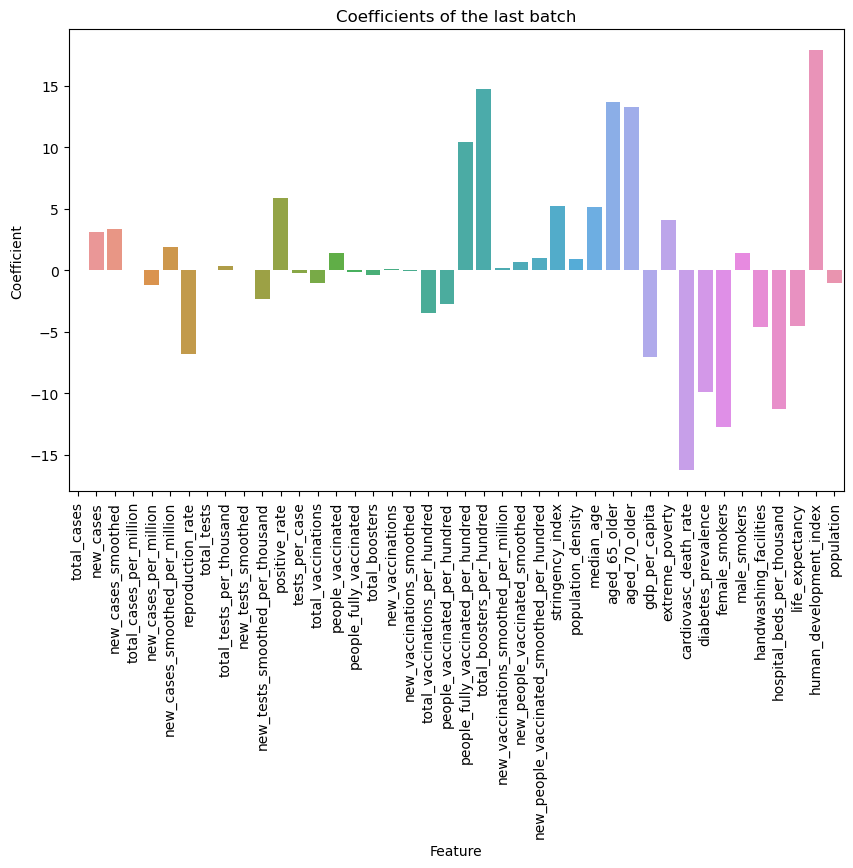

In [ ]:
#graphing the coefficients of the last batch
plt.figure(figsize=(10, 6))
fig_mv_variables = sns.barplot(
    x = train_colum_names,
    y = coefficients_last_batch

)
fig_mv_variables.set(
    title="Coefficients of the last batch",
    xlabel="Feature",
    ylabel="Coefficient"

)
plt.xticks(rotation=90)
plt.show()


##### 2.1.3 Standard linear Regression on scaled data (Function adapted from tutorial 7) - All time periods

Comment: below we can see that the last batch fits the prediction the best in terms of RMSE: it has by far the lowest RMSE. However, even for the best batch the RMSE values are still relatively high. An RMSE of 30 for instance means in our case that the average deviation between the predicted new deaths and the actual new deaths is 30. The second bacth has the lowest R2 value. In training sets 1 and 5 the model does well on the training data but extremely poor on the test data (which is usually a result of overfitting)

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
coefficients_LR = {'Category': train_colum_names}
LR = LinearRegression()

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    LR.fit(X_train_scaled1, y_train1)
    get_scores(LR, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = LR.coef_
    coefficients_LR[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.762, RMSE: 71.994, MSE: 5183.208, MAE: 28.931
Test set score: R2 score: -0.337, RMSE: 113.665, MSE: 12919.680, MAE: 39.011

Training set score: R2 score: 0.742, RMSE: 65.881, MSE: 4340.365, MAE: 25.790
Test set score: R2 score: 0.851, RMSE: 88.447, MSE: 7822.899, MAE: 38.250

Training set score: R2 score: 0.794, RMSE: 113.927, MSE: 12979.380, MAE: 46.631
Test set score: R2 score: 0.560, RMSE: 159.302, MSE: 25377.260, MAE: 49.328

Training set score: R2 score: 0.669, RMSE: 99.958, MSE: 9991.570, MAE: 43.325
Test set score: R2 score: 0.506, RMSE: 119.570, MSE: 14296.947, MAE: 50.481

Training set score: R2 score: 0.580, RMSE: 103.138, MSE: 10637.373, MAE: 36.308
Test set score: R2 score: -2.302, RMSE: 75.861, MSE: 5754.832, MAE: 32.869

Training set score: R2 score: 0.651, RMSE: 29.938, MSE: 896.298, MAE: 10.331
Test set score: R2 score: 0.680, RMSE: 28.597, MSE: 817.764, MAE: 10.280



In [ ]:
#here are the coefficients for all 6 timeframes for each category
coefficients_LR_df = pd.DataFrame(coefficients_LR)
coefficients_LR_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.016110,1.041948,13.376760,1.884813,18.202031,5.300392
1,new_cases,3.096995,4.747502,5.571394,12.922311,4.192045,0.802094
2,new_cases_smoothed,3.332440,3.050503,12.114246,4.991056,0.117589,-1.241548
3,total_cases_per_million,0.012200,3.540740,-7.711919,-4.321849,-12.651978,-3.267929
4,new_cases_per_million,-1.184882,-1.092662,5.217767,-1.859617,-1.839790,-0.044965
5,new_cases_smoothed_per_million,1.876159,-0.801806,-7.465925,-5.152135,-3.629825,0.202977
6,reproduction_rate,-6.829386,-2.974131,-7.198717,-9.579513,-9.396661,-1.635029
7,total_tests,0.009674,-0.011656,0.345057,-0.144495,0.458021,2.258175
8,total_tests_per_thousand,0.366150,-0.898714,-4.031706,0.075947,1.734710,-1.181101
9,new_tests_smoothed,0.014682,-0.008245,0.363486,-0.405423,1.471792,-0.840742


In [ ]:
#filtering all values from the previous table that are above a certain threshhold, to make strong positive correlations visible
threshold = 10
coefficients_LR_df_dropped = coefficients_LR_df.drop('Category', axis=1)
coefficients_LR_filtered_positive_df = coefficients_LR_df_dropped.applymap(lambda x: x if x > threshold else None)
coefficients_LR_filtered_positive_df.insert(0, 'Category', train_colum_names)
coefficients_LR_filtered_positive_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,NaN,NaN,13.376760,NaN,18.202031,NaN
1,new_cases,NaN,NaN,NaN,12.922311,NaN,NaN
2,new_cases_smoothed,NaN,NaN,12.114246,NaN,NaN,NaN
3,total_cases_per_million,NaN,NaN,NaN,NaN,NaN,NaN
4,new_cases_per_million,NaN,NaN,NaN,NaN,NaN,NaN
5,new_cases_smoothed_per_million,NaN,NaN,NaN,NaN,NaN,NaN
6,reproduction_rate,NaN,NaN,NaN,NaN,NaN,NaN
7,total_tests,NaN,NaN,NaN,NaN,NaN,NaN
8,total_tests_per_thousand,NaN,NaN,NaN,NaN,NaN,NaN
9,new_tests_smoothed,NaN,NaN,NaN,NaN,NaN,NaN


Comment: It seems there that median age and human development index are, considerig all time periods, the most important positively correlated predictors of new deaths. Naturally, the median age of a society and development index go hand in hand. People vaccinated is also positvely correlated strongly in the later years. 

In [ ]:
#filtering all values from the previous table that are below a certain threshhold, to make strong negative correlations visible
threshold = -10
coefficients_LR_df_dropped = coefficients_LR_df.drop('Category', axis=1)
coefficients_LR_filtered_positive_df = coefficients_LR_df_dropped.applymap(lambda x: x if x < threshold else None)
coefficients_LR_filtered_positive_df.insert(0, 'Category', train_colum_names)
coefficients_LR_filtered_positive_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,NaN,NaN,NaN,NaN,NaN,NaN
1,new_cases,NaN,NaN,NaN,NaN,NaN,NaN
2,new_cases_smoothed,NaN,NaN,NaN,NaN,NaN,NaN
3,total_cases_per_million,NaN,NaN,NaN,NaN,-12.651978,NaN
4,new_cases_per_million,NaN,NaN,NaN,NaN,NaN,NaN
5,new_cases_smoothed_per_million,NaN,NaN,NaN,NaN,NaN,NaN
6,reproduction_rate,NaN,NaN,NaN,NaN,NaN,NaN
7,total_tests,NaN,NaN,NaN,NaN,NaN,NaN
8,total_tests_per_thousand,NaN,NaN,NaN,NaN,NaN,NaN
9,new_tests_smoothed,NaN,NaN,NaN,NaN,NaN,NaN


Comment: People fully vaccinated per hundred and life expectancy are the most negatively correlated across the board. Life expectancy seems to be telling a similar story as. To me these number seem very contradictory

##### 2.1.4 Ridge Regression (Lambda = 1) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
coefficients_ridge = {'Category': train_colum_names}

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    ridge.fit(X_train_scaled1, y_train1)
    get_scores(ridge, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = ridge.coef_
    coefficients_ridge[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.762, RMSE: 71.994, MSE: 5183.208, MAE: 28.927
Test set score: R2 score: -0.337, RMSE: 113.664, MSE: 12919.613, MAE: 39.008

Training set score: R2 score: 0.742, RMSE: 65.881, MSE: 4340.366, MAE: 25.788
Test set score: R2 score: 0.851, RMSE: 88.446, MSE: 7822.748, MAE: 38.248

Training set score: R2 score: 0.794, RMSE: 113.927, MSE: 12979.381, MAE: 46.626
Test set score: R2 score: 0.560, RMSE: 159.300, MSE: 25376.545, MAE: 49.324

Training set score: R2 score: 0.669, RMSE: 99.958, MSE: 9991.572, MAE: 43.318
Test set score: R2 score: 0.506, RMSE: 119.570, MSE: 14297.084, MAE: 50.475

Training set score: R2 score: 0.580, RMSE: 103.138, MSE: 10637.377, MAE: 36.300
Test set score: R2 score: -2.302, RMSE: 75.860, MSE: 5754.806, MAE: 32.859

Training set score: R2 score: 0.651, RMSE: 29.938, MSE: 896.299, MAE: 10.326
Test set score: R2 score: 0.680, RMSE: 28.592, MSE: 817.484, MAE: 10.275



In [ ]:
coefficients_ridge_df = pd.DataFrame(coefficients_ridge)
coefficients_ridge_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.016110,1.041989,13.376453,1.883893,18.204618,5.311504
1,new_cases,3.097003,4.747497,5.571680,12.922282,4.192052,0.802103
2,new_cases_smoothed,3.332457,3.050401,12.113917,4.991950,0.117991,-1.241608
3,total_cases_per_million,0.012199,3.539303,-7.708576,-4.304647,-12.628993,-3.271655
4,new_cases_per_million,-1.184687,-1.092632,5.216176,-1.859845,-1.839774,-0.044971
5,new_cases_smoothed_per_million,1.875994,-0.800327,-7.460181,-5.150759,-3.628536,0.202711
6,reproduction_rate,-6.828012,-2.976201,-7.197266,-9.580397,-9.391135,-1.631810
7,total_tests,0.009679,-0.011694,0.345041,-0.144009,0.456005,2.254254
8,total_tests_per_thousand,0.365665,-0.898250,-4.030187,0.078066,1.734843,-1.182701
9,new_tests_smoothed,0.014669,-0.008234,0.363478,-0.405217,1.468981,-0.839538


In [ ]:
#this output shows the difference between the normal linear regression and the ridge regression at lambda = 1
def convert_to_float(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Convert all values to float, handling errors
coefficients_LR_df = convert_to_float(coefficients_LR_df)
difference =  coefficients_LR_df - coefficients_ridge_df
difference["Category"] = train_colum_names
difference

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,2.546531e-07,-4.115249e-05,3.071436e-04,0.000920,-0.002588,-0.011112
1,new_cases,-8.252956e-06,4.593484e-06,-2.868441e-04,0.000030,-0.000006,-0.000009
2,new_cases_smoothed,-1.700303e-05,1.015785e-04,3.290330e-04,-0.000894,-0.000401,0.000060
3,total_cases_per_million,4.218372e-07,1.436420e-03,-3.342665e-03,-0.017202,-0.022985,0.003725
4,new_cases_per_million,-1.941956e-04,-3.071828e-05,1.591210e-03,0.000228,-0.000016,0.000006
5,new_cases_smoothed_per_million,1.654501e-04,-1.479290e-03,-5.743764e-03,-0.001377,-0.001289,0.000265
6,reproduction_rate,-1.374092e-03,2.070358e-03,-1.451117e-03,0.000884,-0.005526,-0.003218
7,total_tests,-4.979304e-06,3.748874e-05,1.567081e-05,-0.000485,0.002016,0.003921
8,total_tests_per_thousand,4.844480e-04,-4.643816e-04,-1.518543e-03,-0.002119,-0.000133,0.001600
9,new_tests_smoothed,1.288279e-05,-1.178805e-05,7.282667e-06,-0.000206,0.002811,-0.001205


##### 2.1.5 Ridge Regression (Lambda = 10) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
ridge_10 = Ridge(alpha=10)
ridge_10.fit(X_train_scaled, y_train)
coefficients_ridge_10 = {'Category': train_colum_names}

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    ridge_10.fit(X_train_scaled1, y_train1)
    get_scores(ridge_10, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = ridge_10.coef_
    coefficients_ridge_10[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.762, RMSE: 71.995, MSE: 5183.229, MAE: 28.895
Test set score: R2 score: -0.337, RMSE: 113.663, MSE: 12919.203, MAE: 38.982

Training set score: R2 score: 0.742, RMSE: 65.882, MSE: 4340.394, MAE: 25.763
Test set score: R2 score: 0.851, RMSE: 88.439, MSE: 7821.473, MAE: 38.227

Training set score: R2 score: 0.794, RMSE: 113.927, MSE: 12979.435, MAE: 46.586
Test set score: R2 score: 0.560, RMSE: 159.280, MSE: 25370.229, MAE: 49.284

Training set score: R2 score: 0.669, RMSE: 99.958, MSE: 9991.692, MAE: 43.254
Test set score: R2 score: 0.506, RMSE: 119.575, MSE: 14298.252, MAE: 50.420

Training set score: R2 score: 0.580, RMSE: 103.140, MSE: 10637.768, MAE: 36.231
Test set score: R2 score: -2.302, RMSE: 75.860, MSE: 5754.791, MAE: 32.778

Training set score: R2 score: 0.651, RMSE: 29.941, MSE: 896.438, MAE: 10.292
Test set score: R2 score: 0.681, RMSE: 28.553, MSE: 815.265, MAE: 10.243



##### 2.1.6 Ridge Regression (Lambda = 100) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
ridge_100 = Ridge(alpha=100)
ridge_100.fit(X_train_scaled, y_train)
coefficients_ridge_100 = {'Category': train_colum_names}

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    ridge_100.fit(X_train_scaled1, y_train1)
    get_scores(ridge_100, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = ridge_100.coef_
    coefficients_ridge_100[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.762, RMSE: 72.003, MSE: 5184.435, MAE: 28.640
Test set score: R2 score: -0.338, RMSE: 113.678, MSE: 12922.610, MAE: 38.789

Training set score: R2 score: 0.742, RMSE: 65.896, MSE: 4342.315, MAE: 25.574
Test set score: R2 score: 0.851, RMSE: 88.396, MSE: 7813.786, MAE: 38.059

Training set score: R2 score: 0.794, RMSE: 113.942, MSE: 12982.672, MAE: 46.289
Test set score: R2 score: 0.561, RMSE: 159.110, MSE: 25315.833, MAE: 49.018

Training set score: R2 score: 0.668, RMSE: 99.993, MSE: 9998.568, MAE: 42.815
Test set score: R2 score: 0.506, RMSE: 119.604, MSE: 14305.162, MAE: 50.037

Training set score: R2 score: 0.580, RMSE: 103.217, MSE: 10653.722, MAE: 35.817
Test set score: R2 score: -2.306, RMSE: 75.915, MSE: 5763.063, MAE: 32.208

Training set score: R2 score: 0.650, RMSE: 30.002, MSE: 900.103, MAE: 10.177
Test set score: R2 score: 0.685, RMSE: 28.362, MSE: 804.378, MAE: 10.188



[Timestamp('2020-05-30 00:00:00'), Timestamp('2020-05-31 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-06 00:00:00'), Timestamp('2020-06-07 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-09 00:00:00'), Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-06-17 00:00:00'), Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'), Timestamp('2020-06-20 00:00:00'), Timestamp('2020-06-21 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-23 00:00:00'), Timestamp('2020-06-24 00:00:00'), Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00'), Timestamp('2020-06-27 00:00:00'), Timestamp('20

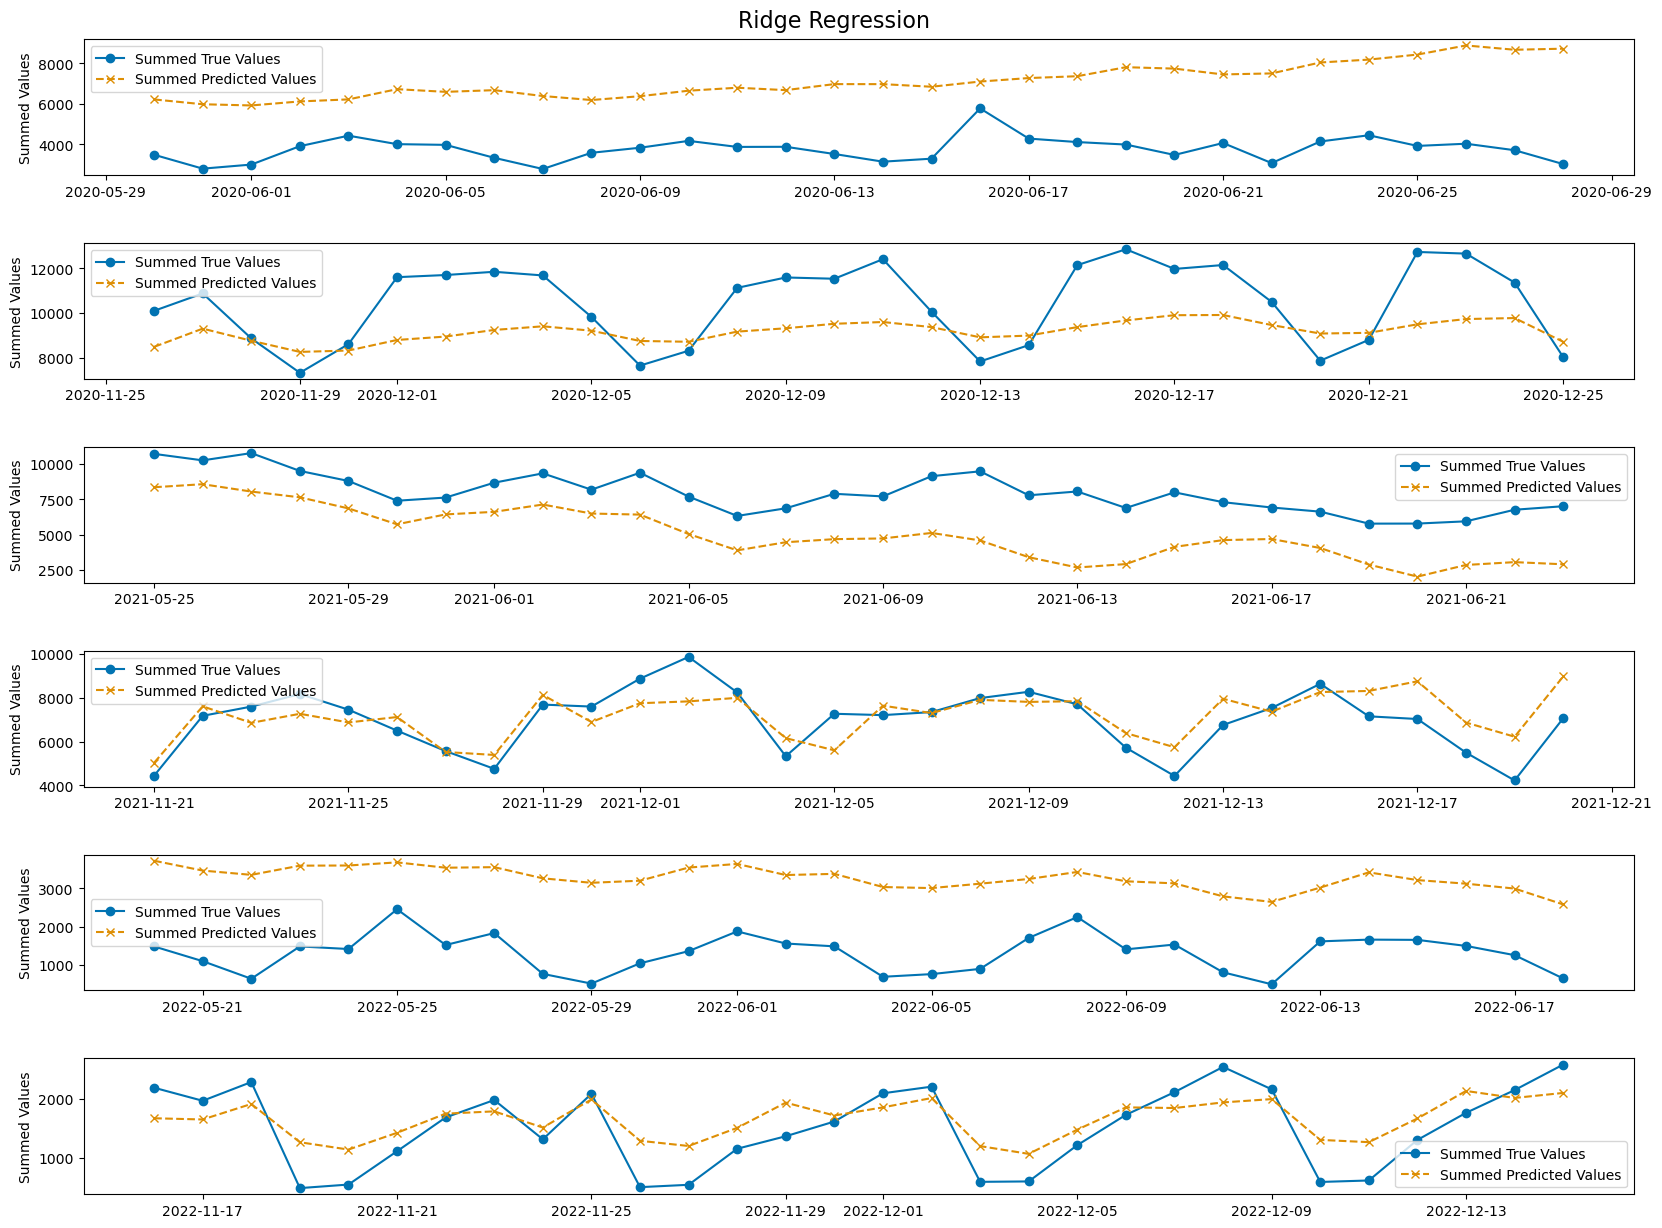

In [ ]:
#Sevis graphing tool to visualize the difference between summed predicted values and summed actual values
mse_list=[]
r2_list=[]
feature_importances_list = []
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = LinearRegression()

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]
    values = big_list[i]
    print (values)
    #axs[i].set_xticks(values)

    fig.suptitle('Ridge Regression', fontsize=16, y=0.9)
    axs[i].plot(values, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(values, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    #axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    #axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()
    plt.subplots_adjust(hspace=0.5)
    print()


In [ ]:
coefficients_ridge_100_df = pd.DataFrame(coefficients_ridge_100)
coefficients_ridge_100_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.015431,1.045168,13.351910,1.805156,18.366332,5.922755
1,new_cases,3.097483,4.746589,5.599358,12.919435,4.192073,0.802461
2,new_cases_smoothed,3.334347,3.042997,12.081522,5.063705,0.142695,-1.244358
3,total_cases_per_million,0.011443,3.426801,-7.435949,-2.924202,-11.058899,-3.391029
4,new_cases_per_million,-1.170827,-1.089998,5.062707,-1.878754,-1.836278,-0.045204
5,new_cases_smoothed_per_million,1.865111,-0.676491,-6.966559,-5.021106,-3.549569,0.191114
6,reproduction_rate,-6.702268,-3.145495,-7.110184,-9.608730,-8.979636,-1.518310
7,total_tests,0.009942,-0.014588,0.343905,-0.106186,0.333268,2.009888
8,total_tests_per_thousand,0.330718,-0.862802,-3.929997,0.218293,1.679040,-1.120089
9,new_tests_smoothed,0.013360,-0.007310,0.363347,-0.391858,1.295475,-0.761536


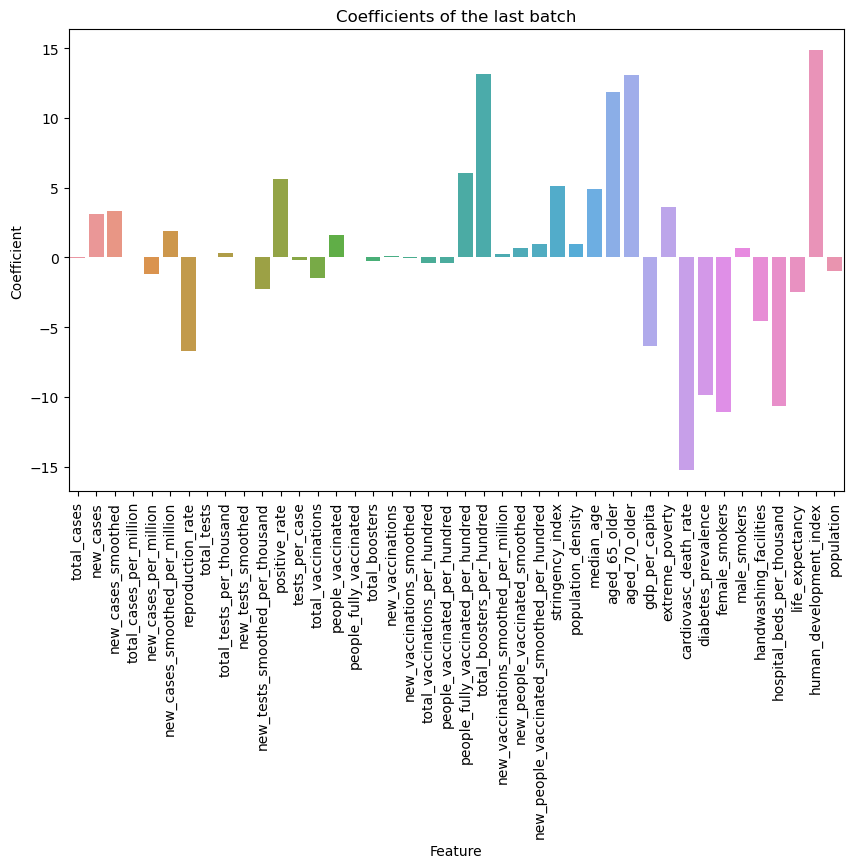

In [ ]:
#graphing the missing values per column
plt.figure(figsize=(10, 6))
fig_mv_variables = sns.barplot(
    x = coefficients_ridge_100_df["Category"],
    y = coefficients_ridge_100_df["set1"]

)
fig_mv_variables.set(
    title="Coefficients of the last batch",
    xlabel="Feature",
    ylabel="Coefficient"

)
plt.xticks(rotation=90)
plt.show()

#plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")  

In [ ]:
coefficients_ridge_100_df_dropped = coefficients_ridge_100_df.drop('Category', axis=1)
coefficients_ridge_100_filtered_positive_df = coefficients_ridge_100_df_dropped.applymap(lambda x: x if x > threshold else None)
coefficients_ridge_100_filtered_positive_df.insert(0, 'Category', train_colum_names)
coefficients_ridge_100_filtered_positive_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.015431,1.045168,13.351910,1.805156,18.366332,5.922755
1,new_cases,3.097483,4.746589,5.599358,12.919435,4.192073,0.802461
2,new_cases_smoothed,3.334347,3.042997,12.081522,5.063705,0.142695,-1.244358
3,total_cases_per_million,0.011443,3.426801,-7.435949,-2.924202,NaN,-3.391029
4,new_cases_per_million,-1.170827,-1.089998,5.062707,-1.878754,-1.836278,-0.045204
5,new_cases_smoothed_per_million,1.865111,-0.676491,-6.966559,-5.021106,-3.549569,0.191114
6,reproduction_rate,-6.702268,-3.145495,-7.110184,-9.608730,-8.979636,-1.518310
7,total_tests,0.009942,-0.014588,0.343905,-0.106186,0.333268,2.009888
8,total_tests_per_thousand,0.330718,-0.862802,-3.929997,0.218293,1.679040,-1.120089
9,new_tests_smoothed,0.013360,-0.007310,0.363347,-0.391858,1.295475,-0.761536


In [ ]:
threshold = -10

# Apply the threshold filter to the DataFrame, considering the absolute value of each element
coefficients_ridge_100_df_dropped = coefficients_ridge_100_df.drop('Category', axis=1)
coefficients_ridge_100_filtered_negative_df = coefficients_ridge_100_df_dropped.applymap(lambda x: x if x < threshold else None)
coefficients_ridge_100_filtered_negative_df.insert(0, 'Category', train_colum_names)
coefficients_ridge_100_filtered_negative_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,NaN,NaN,NaN,NaN,NaN,NaN
1,new_cases,NaN,NaN,NaN,NaN,NaN,NaN
2,new_cases_smoothed,NaN,NaN,NaN,NaN,NaN,NaN
3,total_cases_per_million,NaN,NaN,NaN,NaN,-11.058899,NaN
4,new_cases_per_million,NaN,NaN,NaN,NaN,NaN,NaN
5,new_cases_smoothed_per_million,NaN,NaN,NaN,NaN,NaN,NaN
6,reproduction_rate,NaN,NaN,NaN,NaN,NaN,NaN
7,total_tests,NaN,NaN,NaN,NaN,NaN,NaN
8,total_tests_per_thousand,NaN,NaN,NaN,NaN,NaN,NaN
9,new_tests_smoothed,NaN,NaN,NaN,NaN,NaN,NaN


##### 2.1.7 Lasso Regression (Lambda = 1) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
coefficients_lasso = {'Category': train_colum_names}
lasso = Lasso()

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    lasso.fit(X_train_scaled1, y_train1)
    get_scores(lasso, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = lasso.coef_
    coefficients_lasso[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.759, RMSE: 72.497, MSE: 5255.879, MAE: 25.852
Test set score: R2 score: -0.351, RMSE: 114.237, MSE: 13050.127, MAE: 36.853

Training set score: R2 score: 0.737, RMSE: 66.527, MSE: 4425.812, MAE: 24.226
Test set score: R2 score: 0.851, RMSE: 88.409, MSE: 7816.083, MAE: 36.089

Training set score: R2 score: 0.792, RMSE: 114.582, MSE: 13129.044, MAE: 44.160
Test set score: R2 score: 0.569, RMSE: 157.657, MSE: 24855.749, MAE: 46.031

Training set score: R2 score: 0.663, RMSE: 100.821, MSE: 10164.904, MAE: 40.738
Test set score: R2 score: 0.509, RMSE: 119.271, MSE: 14225.630, MAE: 47.842

Training set score: R2 score: 0.571, RMSE: 104.235, MSE: 10864.990, MAE: 34.056
Test set score: R2 score: -2.404, RMSE: 77.031, MSE: 5933.847, MAE: 29.505

Training set score: R2 score: 0.633, RMSE: 30.724, MSE: 943.980, MAE: 9.584
Test set score: R2 score: 0.689, RMSE: 28.199, MSE: 795.197, MAE: 9.609



In [ ]:
coefficients_lasso_df = pd.DataFrame(coefficients_lasso)
coefficients_lasso_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.005190,1.101113,13.037874,1.171821,19.096112,7.609707
1,new_cases,3.028585,4.691977,6.164333,12.966341,4.195215,0.794127
2,new_cases_smoothed,3.406457,3.035270,11.481005,5.551073,0.161108,-1.200607
3,total_cases_per_million,-0.001430,2.550904,-3.856720,-0.000000,-0.708714,-0.808673
4,new_cases_per_million,-0.656886,-0.863696,0.245112,-2.100223,-1.893452,-0.033894
5,new_cases_smoothed_per_million,1.433885,-0.000000,-0.000000,-3.376754,-3.041442,0.000000
6,reproduction_rate,-5.226219,-2.974682,-6.070612,-7.560844,-5.094026,-0.000000
7,total_tests,0.007906,-0.019862,0.341656,0.188167,0.061167,0.630463
8,total_tests_per_thousand,0.047689,-0.746167,-3.530057,-0.000000,0.000000,-0.021698
9,new_tests_smoothed,-0.002263,-0.008141,0.399044,-0.336880,0.929606,-0.192686


In [ ]:
def convert_to_float(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Convert all values to float, handling errors
coefficients_LR_df = convert_to_float(coefficients_LR_df)
difference =  coefficients_LR_df - coefficients_lasso_df
difference["Category"] = train_colum_names
difference

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.010919,-0.059165,0.338886,0.712991,-0.894081,-2.309315
1,new_cases,0.068410,0.055525,-0.592940,-0.044030,-0.003170,0.007967
2,new_cases_smoothed,-0.074017,0.015233,0.633241,-0.560017,-0.043519,-0.040941
3,total_cases_per_million,0.013630,0.989836,-3.855199,-4.321849,-11.943264,-2.459256
4,new_cases_per_million,-0.527996,-0.228966,4.972655,0.240606,0.053662,-0.011071
5,new_cases_smoothed_per_million,0.442274,-0.801806,-7.465925,-1.775381,-0.588383,0.202977
6,reproduction_rate,-1.603168,0.000551,-1.128105,-2.018669,-4.302635,-1.635029
7,total_tests,0.001769,0.008205,0.003401,-0.332662,0.396854,1.627712
8,total_tests_per_thousand,0.318461,-0.152547,-0.501648,0.075947,1.734710,-1.159403
9,new_tests_smoothed,0.016945,-0.000105,-0.035559,-0.068544,0.542186,-0.648057


##### 2.1.8 Lasso Regression (Lambda = 10) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
coefficients_lasso_10 = {'Category': train_colum_names}
lasso_10 = Lasso(alpha=10)

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    lasso_10.fit(X_train_scaled1, y_train1)
    get_scores(lasso_10, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    new_column_name = f"set{i+1}"
    new_data = lasso_10.coef_
    coefficients_lasso_10[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.741, RMSE: 75.180, MSE: 5651.990, MAE: 20.606
Test set score: R2 score: -0.388, RMSE: 115.803, MSE: 13410.298, MAE: 32.453

Training set score: R2 score: 0.721, RMSE: 68.617, MSE: 4708.295, MAE: 22.100
Test set score: R2 score: 0.842, RMSE: 90.986, MSE: 8278.406, MAE: 34.020

Training set score: R2 score: 0.782, RMSE: 117.160, MSE: 13726.357, MAE: 42.579
Test set score: R2 score: 0.623, RMSE: 147.325, MSE: 21704.572, MAE: 44.180

Training set score: R2 score: 0.640, RMSE: 104.205, MSE: 10858.631, MAE: 34.029
Test set score: R2 score: 0.481, RMSE: 122.614, MSE: 15034.227, MAE: 40.856

Training set score: R2 score: 0.556, RMSE: 106.103, MSE: 11257.762, MAE: 29.828
Test set score: R2 score: -2.287, RMSE: 75.695, MSE: 5729.691, MAE: 26.878

Training set score: R2 score: 0.604, RMSE: 31.890, MSE: 1016.965, MAE: 8.655
Test set score: R2 score: 0.657, RMSE: 29.591, MSE: 875.623, MAE: 8.513



In [ ]:
coefficients_lasso_10_df = pd.DataFrame(coefficients_lasso_10)
coefficients_lasso_10_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,0.003648,1.133717,12.083633,0.000000,17.206288,6.085805
1,new_cases,2.899811,4.202027,5.848159,12.868052,4.333933,0.726022
2,new_cases_smoothed,3.577761,3.933300,11.591392,6.394106,0.000000,-0.723456
3,total_cases_per_million,-0.007650,0.000000,0.000000,-0.000000,-0.000000,-0.000000
4,new_cases_per_million,0.000000,0.000000,0.000000,-0.287826,-2.976663,-0.030319
5,new_cases_smoothed_per_million,0.708810,0.000000,0.000000,-0.000000,-0.538337,-0.000000
6,reproduction_rate,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
7,total_tests,-0.000976,-0.029028,0.287006,-0.000000,0.000000,0.056677
8,total_tests_per_thousand,-0.020841,-0.190280,-0.000000,-0.000000,-0.000000,-0.000000
9,new_tests_smoothed,-0.007056,-0.010034,0.404313,-0.324556,0.577196,0.000000


In [ ]:
def convert_to_float(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Convert all values to float, handling errors
coefficients_LR_df = convert_to_float(coefficients_LR_df)
difference =  coefficients_LR_df - coefficients_lasso_10_df
difference["Category"] = train_colum_names
difference

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.019757,-0.091769,1.293127,1.884813,0.995743,-0.785413
1,new_cases,0.197184,0.545476,-0.276765,0.054259,-0.141888,0.076072
2,new_cases_smoothed,-0.245321,-0.882797,0.522855,-1.403050,0.117589,-0.518092
3,total_cases_per_million,0.019850,3.540740,-7.711919,-4.321849,-12.651978,-3.267929
4,new_cases_per_million,-1.184882,-1.092662,5.217767,-1.571791,1.136873,-0.014646
5,new_cases_smoothed_per_million,1.167349,-0.801806,-7.465925,-5.152135,-3.091488,0.202977
6,reproduction_rate,-6.829386,-2.974131,-7.198717,-9.579513,-9.396661,-1.635029
7,total_tests,0.010651,0.017372,0.058051,-0.144495,0.458021,2.201498
8,total_tests_per_thousand,0.386991,-0.708434,-4.031706,0.075947,1.734710,-1.181101
9,new_tests_smoothed,0.021738,0.001789,-0.040828,-0.080867,0.894597,-0.840742


##### 2.1.9 Lasso Regression (Lambda = 100) - All time periods

In [ ]:
# this cell calculates the coefficients for all 6 sets and the R2 scores
coefficients_lasso_100 = {'Category': train_colum_names}
lasso_100 = Lasso(alpha=100)
test_predictions = []

# get scores:
for i in range(len(y_scaled_train_sets)):
    X_train_scaled1 = x_scaled_train_sets[i]
    y_train1        = y_scaled_train_sets[i]
    scaled_test1    = scaled_test_sets[i]
    true_y_values1  = true_y_values[i]
    lasso_100.fit(X_train_scaled1, y_train1)
    scores = get_scores(lasso_100, X_train_scaled1, y_train1, scaled_test1, true_y_values1)
    test_predictions.append(scores)
    new_column_name = f"set{i+1}"
    new_data = lasso_100.coef_
    coefficients_lasso_100[new_column_name] = new_data
    print ()

Training set score: R2 score: 0.736, RMSE: 75.850, MSE: 5753.289, MAE: 20.860
Test set score: R2 score: -0.269, RMSE: 110.735, MSE: 12262.232, MAE: 31.059

Training set score: R2 score: 0.698, RMSE: 71.323, MSE: 5086.928, MAE: 25.502
Test set score: R2 score: 0.837, RMSE: 92.473, MSE: 8551.339, MAE: 36.576

Training set score: R2 score: 0.751, RMSE: 125.344, MSE: 15711.110, MAE: 45.199
Test set score: R2 score: 0.786, RMSE: 111.027, MSE: 12327.012, MAE: 38.671

Training set score: R2 score: 0.606, RMSE: 108.945, MSE: 11868.942, MAE: 36.373
Test set score: R2 score: 0.496, RMSE: 120.855, MSE: 14605.942, MAE: 42.055

Training set score: R2 score: 0.520, RMSE: 110.338, MSE: 12174.522, MAE: 28.401
Test set score: R2 score: -0.684, RMSE: 54.171, MSE: 2934.504, MAE: 21.157

Training set score: R2 score: 0.423, RMSE: 38.512, MSE: 1483.174, MAE: 10.009
Test set score: R2 score: 0.488, RMSE: 36.174, MSE: 1308.549, MAE: 9.402



In [ ]:
values = test_predictions[0]
print (len(values))
""" plt.plot(values, marker='o', linestyle='-', color='b')  # Line plot with markers
plt.title("Values in Array")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show() """

4710


' plt.plot(values, marker=\'o\', linestyle=\'-\', color=\'b\')  # Line plot with markers\nplt.title("Values in Array")\nplt.xlabel("Index")\nplt.ylabel("Value")\nplt.grid(True)\nplt.show() '

In [ ]:
sns.set_palette("colorblind")

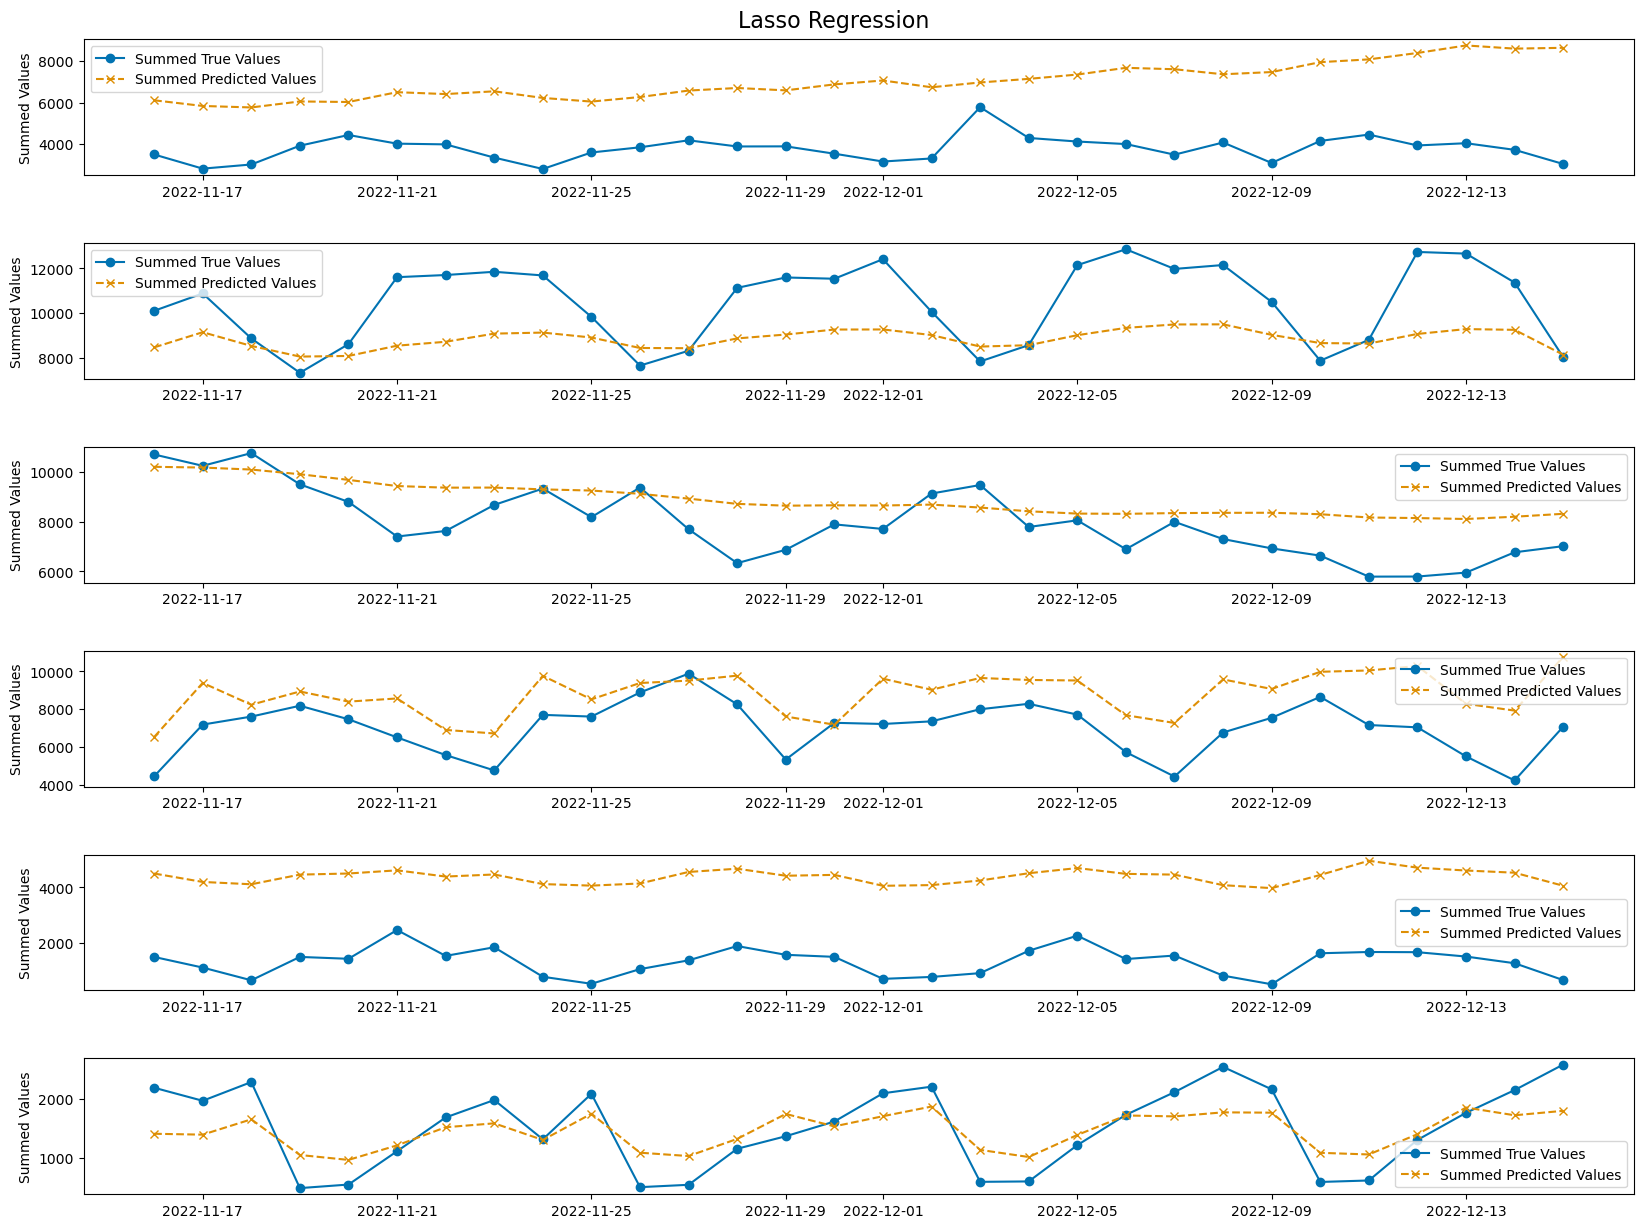

In [ ]:
#Sevis graphing tool to plot the difference between the summed predicted values and the summed actual values.
mse_list=[]
r2_list=[]
feature_importances_list = []
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = Lasso(alpha=100)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]

    fig.suptitle('Lasso Regression', fontsize=16, y=0.9)
    axs[i].plot(sorted_dates, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    #axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    #axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()
    plt.subplots_adjust(hspace=0.5)
    print()

[Timestamp('2020-05-30 00:00:00'), Timestamp('2020-05-31 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-06 00:00:00'), Timestamp('2020-06-07 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-09 00:00:00'), Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-06-17 00:00:00'), Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'), Timestamp('2020-06-20 00:00:00'), Timestamp('2020-06-21 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-23 00:00:00'), Timestamp('2020-06-24 00:00:00'), Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00'), Timestamp('2020-06-27 00:00:00'), Timestamp('20

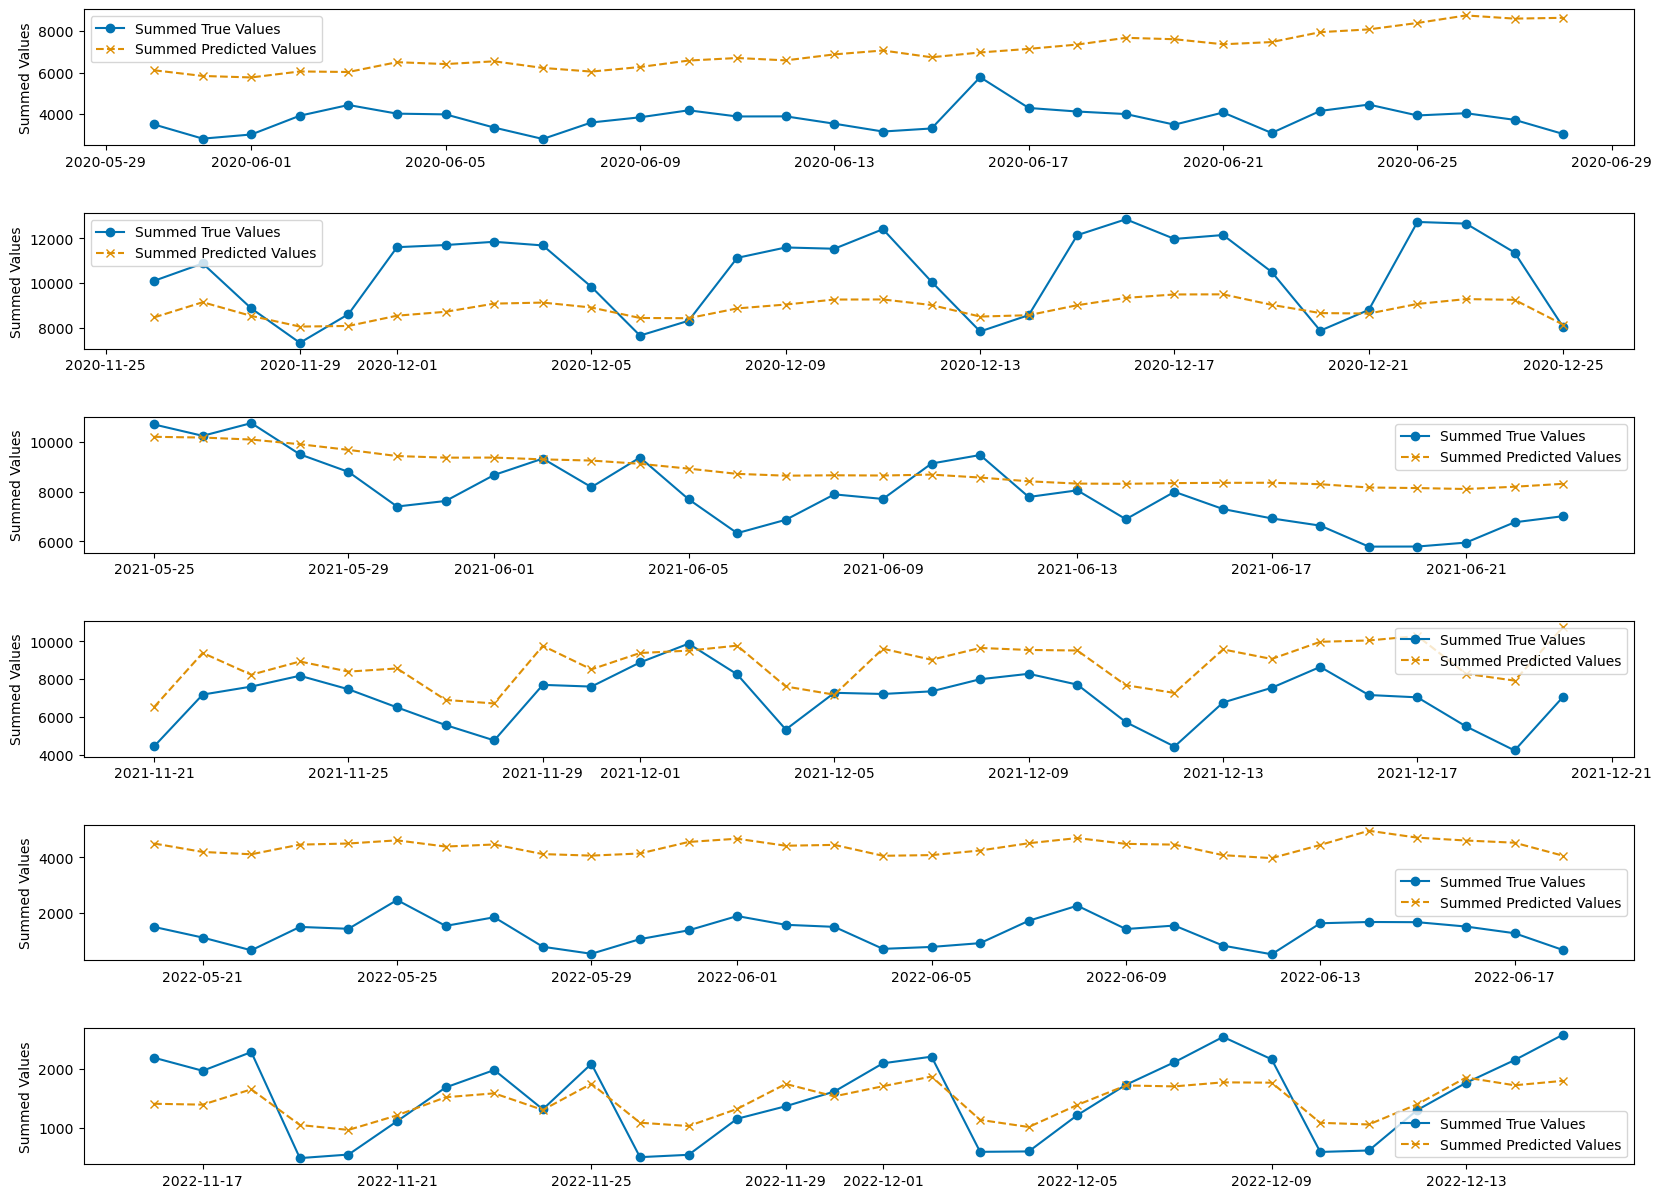

In [ ]:
#Sevis graphing tool
mse_list=[]
r2_list=[]
feature_importances_list = []
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = Lasso(alpha=100)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]
    values = big_list[i]
    print (values)
    #axs[i].set_xticks(values)

    axs[i].plot(values, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(values, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    #axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    #axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()
    plt.subplots_adjust(hspace=0.5)
    print()


In [ ]:
big_list

[[Timestamp('2020-05-30 00:00:00'),
  Timestamp('2020-05-31 00:00:00'),
  Timestamp('2020-06-01 00:00:00'),
  Timestamp('2020-06-02 00:00:00'),
  Timestamp('2020-06-03 00:00:00'),
  Timestamp('2020-06-04 00:00:00'),
  Timestamp('2020-06-05 00:00:00'),
  Timestamp('2020-06-06 00:00:00'),
  Timestamp('2020-06-07 00:00:00'),
  Timestamp('2020-06-08 00:00:00'),
  Timestamp('2020-06-09 00:00:00'),
  Timestamp('2020-06-10 00:00:00'),
  Timestamp('2020-06-11 00:00:00'),
  Timestamp('2020-06-12 00:00:00'),
  Timestamp('2020-06-13 00:00:00'),
  Timestamp('2020-06-14 00:00:00'),
  Timestamp('2020-06-15 00:00:00'),
  Timestamp('2020-06-16 00:00:00'),
  Timestamp('2020-06-17 00:00:00'),
  Timestamp('2020-06-18 00:00:00'),
  Timestamp('2020-06-19 00:00:00'),
  Timestamp('2020-06-20 00:00:00'),
  Timestamp('2020-06-21 00:00:00'),
  Timestamp('2020-06-22 00:00:00'),
  Timestamp('2020-06-23 00:00:00'),
  Timestamp('2020-06-24 00:00:00'),
  Timestamp('2020-06-25 00:00:00'),
  Timestamp('2020-06-26 00:0

In [ ]:
test_data['date'].head(500)
len(test_data)

4770

In [ ]:
sorted_dates

[Timestamp('2022-11-16 00:00:00'),
 Timestamp('2022-11-17 00:00:00'),
 Timestamp('2022-11-18 00:00:00'),
 Timestamp('2022-11-19 00:00:00'),
 Timestamp('2022-11-20 00:00:00'),
 Timestamp('2022-11-21 00:00:00'),
 Timestamp('2022-11-22 00:00:00'),
 Timestamp('2022-11-23 00:00:00'),
 Timestamp('2022-11-24 00:00:00'),
 Timestamp('2022-11-25 00:00:00'),
 Timestamp('2022-11-26 00:00:00'),
 Timestamp('2022-11-27 00:00:00'),
 Timestamp('2022-11-28 00:00:00'),
 Timestamp('2022-11-29 00:00:00'),
 Timestamp('2022-11-30 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2022-12-02 00:00:00'),
 Timestamp('2022-12-03 00:00:00'),
 Timestamp('2022-12-04 00:00:00'),
 Timestamp('2022-12-05 00:00:00'),
 Timestamp('2022-12-06 00:00:00'),
 Timestamp('2022-12-07 00:00:00'),
 Timestamp('2022-12-08 00:00:00'),
 Timestamp('2022-12-09 00:00:00'),
 Timestamp('2022-12-10 00:00:00'),
 Timestamp('2022-12-11 00:00:00'),
 Timestamp('2022-12-12 00:00:00'),
 Timestamp('2022-12-13 00:00:00'),
 Timestamp('2022-12-

In [ ]:
coefficients_lasso_100_df = pd.DataFrame(coefficients_lasso_100)
coefficients_lasso_100_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,0.000000,0.000000,5.430157,0.000000,10.918032,0.000000
1,new_cases,2.773946,4.215977,4.085451,13.404016,4.523012,0.751812
2,new_cases_smoothed,3.487885,4.469631,12.483617,4.210906,0.025145,0.000000
3,total_cases_per_million,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
4,new_cases_per_million,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
5,new_cases_smoothed_per_million,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
6,reproduction_rate,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
7,total_tests,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,total_tests_per_thousand,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
9,new_tests_smoothed,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
def convert_to_float(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Convert all values to float, handling errors
coefficients_LR_df = convert_to_float(coefficients_LR_df)
difference =  coefficients_LR_df - coefficients_lasso_100_df
difference["Category"] = train_colum_names
difference

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,-0.016110,1.041948,7.946603,1.884813,7.283999,5.300392
1,new_cases,0.323049,0.531525,1.485943,-0.481704,-0.330966,0.050283
2,new_cases_smoothed,-0.155445,-1.419128,-0.369370,0.780150,0.092444,-1.241548
3,total_cases_per_million,0.012200,3.540740,-7.711919,-4.321849,-12.651978,-3.267929
4,new_cases_per_million,-1.184882,-1.092662,5.217767,-1.859617,-1.839790,-0.044965
5,new_cases_smoothed_per_million,1.876159,-0.801806,-7.465925,-5.152135,-3.629825,0.202977
6,reproduction_rate,-6.829386,-2.974131,-7.198717,-9.579513,-9.396661,-1.635029
7,total_tests,0.009674,-0.011656,0.345057,-0.144495,0.458021,2.258175
8,total_tests_per_thousand,0.366150,-0.898714,-4.031706,0.075947,1.734710,-1.181101
9,new_tests_smoothed,0.014682,-0.008245,0.363486,-0.405423,1.471792,-0.840742


In [ ]:
coefficients_lasso_100_df["set1"]

0     0.000000
1     2.773946
2     3.487885
3    -0.000000
4     0.000000
5     0.000000
6    -0.000000
7    -0.000000
8    -0.000000
9    -0.000000
10   -0.000000
11    0.000000
12   -0.003787
13   -0.000000
14   -0.000000
15   -0.000000
16   -0.000000
17   -0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32   -0.000000
33   -0.000000
34   -0.000000
35    0.000000
36   -0.000000
37    0.000000
38   -0.000000
39    0.000000
40    0.000000
41   -0.000000
Name: set1, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, 'total_cases'),
  Text(1, 0, 'new_cases'),
  Text(2, 0, 'new_cases_smoothed'),
  Text(3, 0, 'total_cases_per_million'),
  Text(4, 0, 'new_cases_per_million'),
  Text(5, 0, 'new_cases_smoothed_per_million'),
  Text(6, 0, 'reproduction_rate'),
  Text(7, 0, 'total_tests'),
  Text(8, 0, 'total_tests_per_thousand'),
  Text(9, 0, 'new_tests_smoothed'),
  Text(10, 0, 'new_tests_smoothed_per_thousand'),
  Text(11, 0, 'positive_rate'),
  Text(12, 0, 'tests_per_case'),
  Text(13, 0, 'total_vaccinations'),
  Text(14, 0, 'people_vaccinated'),
  Text(15, 0, 'people_fully_vaccinated'),
  Text(16, 0, 'total_boosters'),
  Text(17, 0, 'new_vaccinations'),
  Text(18, 0, 'new_vaccinations_smoothed'),
  Text(19, 0, 'total_vaccinations_per_hundred'),
  Text(20, 0, 'people_vaccinated_per_hundred'),
  Tex

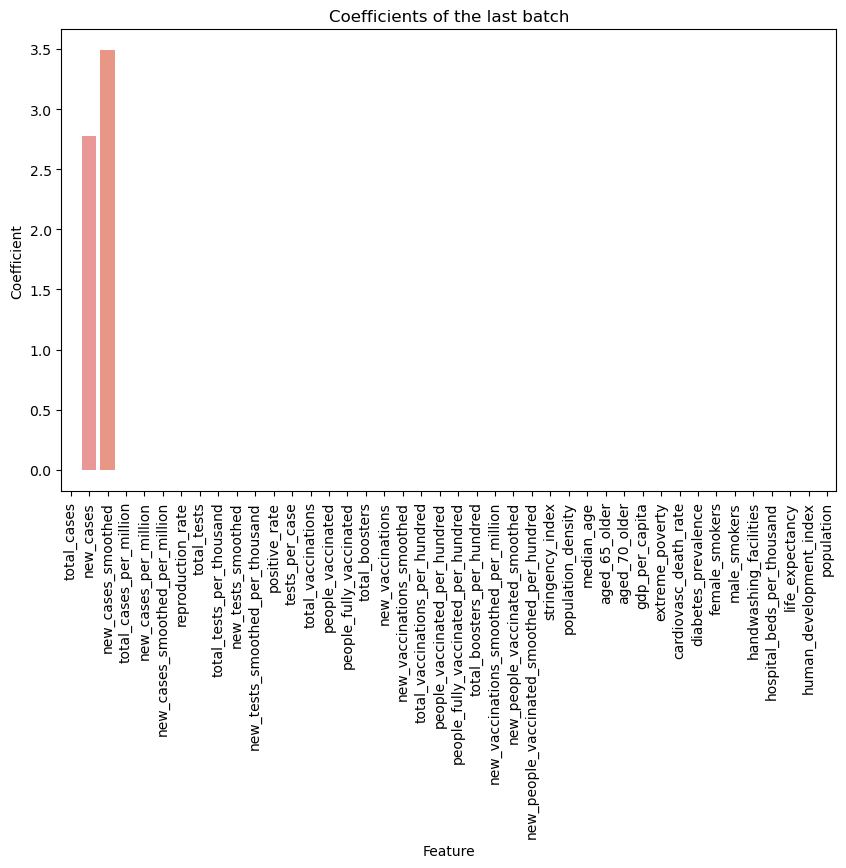

In [ ]:
#graphing the missing values per column
plt.figure(figsize=(10, 6))
fig_mv_variables = sns.barplot(
    x = coefficients_lasso_100_df["Category"],
    y = coefficients_lasso_100_df["set1"]

)
fig_mv_variables.set(
    title="Coefficients of the last batch",
    xlabel="Feature",
    ylabel="Coefficient"

)
plt.xticks(rotation=90)

#plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")   

In [ ]:
coefficients_lasso_100_df_dropped = coefficients_lasso_100_df.drop('Category', axis=1)
coefficients_lasso_100_filtered_positive_df = coefficients_lasso_100_df_dropped.applymap(lambda x: x if x > threshold else None)
coefficients_lasso_100_filtered_positive_df.insert(0, 'Category', train_colum_names)
coefficients_lasso_100_filtered_positive_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,0.000000,0.000000,5.430157,0.000000,10.918032,0.000000
1,new_cases,2.773946,4.215977,4.085451,13.404016,4.523012,0.751812
2,new_cases_smoothed,3.487885,4.469631,12.483617,4.210906,0.025145,0.000000
3,total_cases_per_million,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
4,new_cases_per_million,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
5,new_cases_smoothed_per_million,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
6,reproduction_rate,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
7,total_tests,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,total_tests_per_thousand,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
9,new_tests_smoothed,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
threshold = -5
coefficients_lasso_100_df_dropped = coefficients_lasso_100_df.drop('Category', axis=1)
coefficients_lasso_100_filtered_positive_df = coefficients_lasso_100_df_dropped.applymap(lambda x: x if x < threshold else None)
coefficients_lasso_100_filtered_positive_df.insert(0, 'Category', train_colum_names)
coefficients_lasso_100_filtered_positive_df

,Category,set1,set2,set3,set4,set5,set6
0,total_cases,None,None,None,None,None,None
1,new_cases,None,None,None,None,None,None
2,new_cases_smoothed,None,None,None,None,None,None
3,total_cases_per_million,None,None,None,None,None,None
4,new_cases_per_million,None,None,None,None,None,None
5,new_cases_smoothed_per_million,None,None,None,None,None,None
6,reproduction_rate,None,None,None,None,None,None
7,total_tests,None,None,None,None,None,None
8,total_tests_per_thousand,None,None,None,None,None,None
9,new_tests_smoothed,None,None,None,None,None,None


##### 2.1.10 Visualizations

In [ ]:
sns.set_palette("colorblind")

In [ ]:
train_data_list[0].head(1000)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,total_tests,total_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.714,1.0,1.0,0.286,0.122,0.122,0.017,0.024,0.024,0.007,0.928961,4.600188e+07,920.384294,112096.120537,2.105213,0.106469,111.000000,1.939810e+09,1.012161e+09,8.925080e+08,3.514082e+07,12666.368160,1.163786e+06,136.878000,71.422000,62.980000,2.478000,821.0000,163630.4000,0.011600,8.33,54.422,18.6,2.581,1.337,1803.987,29.474659,597.029,9.59,2.7,37.0,37.746,0.5,64.83,0.511,41128772.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.714,1.0,1.0,0.286,0.122,0.000,0.017,0.024,0.024,0.007,0.928961,4.600188e+07,920.384294,112096.120537,2.105213,0.106469,111.000000,1.939810e+09,1.012161e+09,8.925080e+08,3.514082e+07,12666.368160,1.163786e+06,136.878000,71.422000,62.980000,2.478000,821.0000,163630.4000,0.011600,8.33,54.422,18.6,2.581,1.337,1803.987,29.474659,597.029,9.59,2.7,37.0,37.746,0.5,64.83,0.511,41128772.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.714,1.0,1.0,0.286,0.122,0.000,0.017,0.024,0.024,0.007,0.928961,4.600188e+07,920.384294,112096.120537,2.105213,0.106469,111.000000,1.939810e+09,1.012161e+09,8.925080e+08,3.514082e+07,12666.368160,1.163786e+06,136.878000,71.422000,62.980000,2.478000,821.0000,163630.4000,0.011600,8.33,54.422,18.6,2.581,1.337,1803.987,29.474659,597.029,9.59,2.7,37.0,37.746,0.5,64.83,0.511,41128772.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.714,1.0,1.0,0.286,0.122,0.000,0.017,0.024,0.024,0.007,0.928961,4.600188e+07,920.384294,112096.120537,2.105213,0.106469,111.000000,1.939810e+09,1.012161e+09,8.925080e+08,3.514082e+07,12666.368160,1.163786e+06,136.878000,71.422000,62.980000,2.478000,821.0000,163630.4000,0.011600,8.33,54.422,18.6,2.581,1.337,1803.987,29.474659,597.029,9.59,2.7,37.0,37.746,0.5,64.83,0.511,41128772.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.714,1.0,1.0,0.286,0.122,0.000,0.017,0.024,0.024,0.007,0.928961,4.600188e+07,920.384294,112096.120537,2.105213,0.106469,111.000000,1.939810e+09,1.012161e+09,8.925080e+08,3.514082e+07,12666.368160,1.163786e+06,136.878000,71.422000,62.980000,2.478000,821.0000,163630.4000,0.011600,8.33,54.422,18.6,2.581,1.337,1803.987,29.474659,597.029,9.59,2.7,37.0,37.746,0.5,64.83,0.511,41128772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15523,AZE,Asia,Azerbaijan,2020-05-19,3518.0,131.0,117.857,41.0,1.0,1.143,339.638,12.647,11.378,3.958,0.097,0.110,1.280000,9.857864e+07,11025.140064,50231.850000,5.543210,0.084432,11.867794,1.234081e+07,4.199768e+06,2.919449e+06,5.329186e+06,12064.476718,5.386830e+03,138.047143,46.980000,32.386312,59.449020,583.0100,1305.9300,0.012700,75.93,119.309,32.4,6.018,3.871,15847.419,1.044533,559.812,7.11,0.3,42.5,83.241,4.7,73.00,0.756,10358078.0
15524,AZE,Asia,Azerbaijan,2020-05-20,3631.0,113.0,124.714,43.0,2.0,1.143,350.548,10.909,12.040,4.151,0.193,0.110,1.260000,9.830140e+07,10993.994189,50122.500000,5.530691,0.0

0.6996666666666668
0.6993333333333335
0.6206666666666666


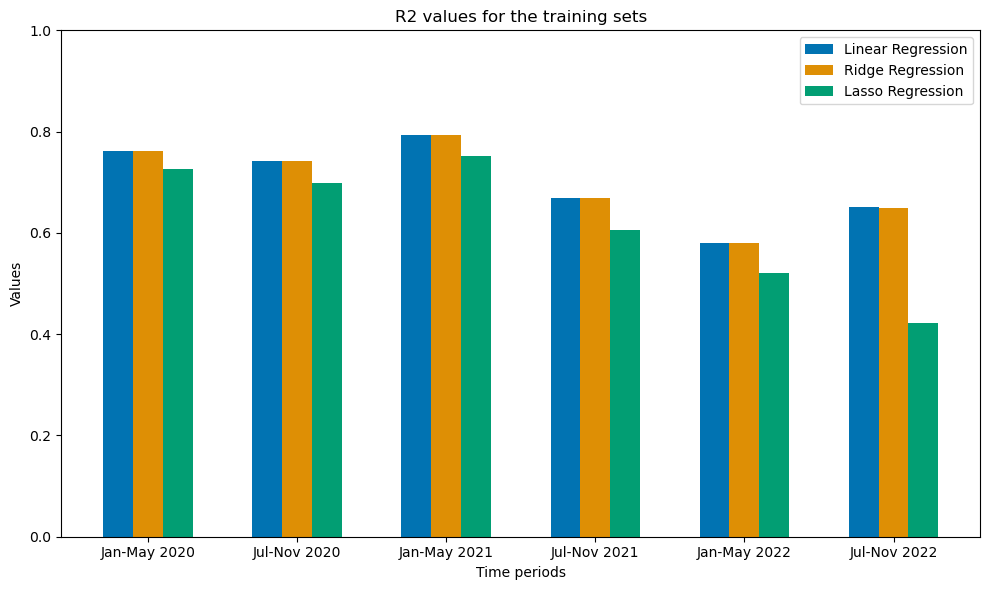

In [ ]:
categories = ['Jan-May 2020', 'Jul-Nov 2020', 'Jan-May 2021', 'Jul-Nov 2021', 'Jan-May 2022', 'Jul-Nov 2022']
values1 = [0.762, 0.742, 0.794, 0.669, 0.580, 0.651]  # First set of values for each category
values2 = [0.762, 0.742, 0.794, 0.668, 0.580, 0.650]  # Second set of values for each category
values3 = [0.726, 0.698, 0.751, 0.606, 0.520, 0.423]  # Third set of values for each category
print (sum(values1)/6)
print (sum(values2)/6)
print (sum(values3)/6)



# Number of categories
N = len(categories)
ind = np.arange(N)  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(ind - width, values1, width, label='Linear Regression')
bar2 = ax.bar(ind, values2, width, label='Ridge Regression')
bar3 = ax.bar(ind + width, values3, width, label='Lasso Regression')

# Adding labels, title, and legend
ax.set_xlabel('Time periods')
ax.set_ylabel('Values')
ax.set_title('R2 values for the training sets')
ax.set_ylim(0, 1)
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


0.5346666666666667
0.5341666666666667
0.478


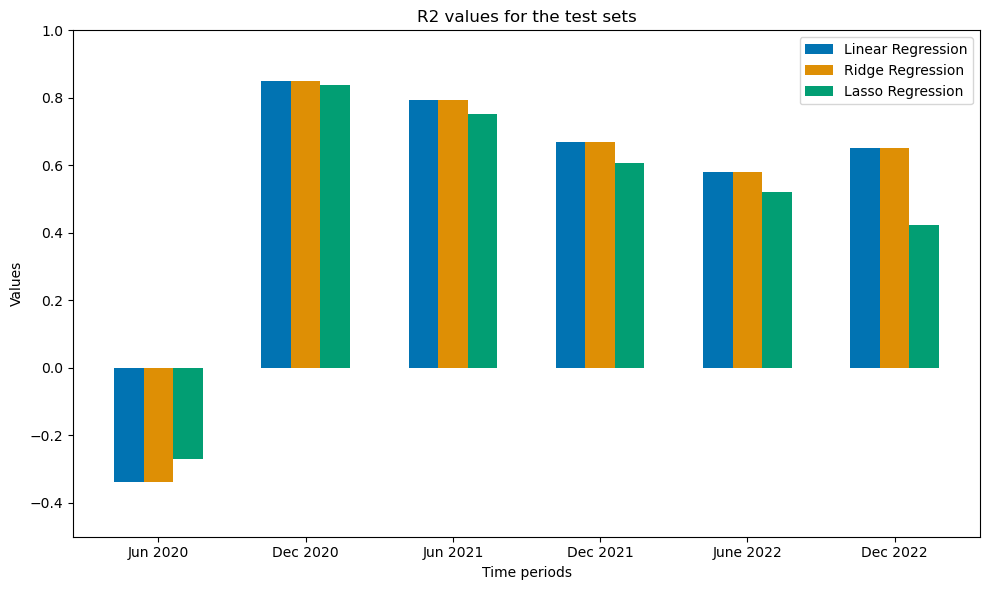

In [ ]:
# Data
categories = ['Jun 2020', 'Dec 2020', 'Jun 2021', 'Dec 2021', 'June 2022', 'Dec 2022']
values1 = [-0.337, 0.851, 0.794, 0.669, 0.580,0.651]  # First set of values for each category
values2 = [-0.338, 0.851, 0.794, 0.668, 0.580, 0.650]  # Second set of values for each category
values3 = [-0.269, 0.837, 0.751, 0.606, 0.520, 0.423]  # Third set of values for each category
print (sum(values1)/6)
print (sum(values2)/6)
print (sum(values3)/6)


# Number of categories
N = len(categories)
ind = np.arange(N)  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(ind - width, values1, width, label='Linear Regression')
bar2 = ax.bar(ind, values2, width, label='Ridge Regression')
bar3 = ax.bar(ind + width, values3, width, label='Lasso Regression')

# Adding labels, title, and legend
ax.set_xlabel('Time periods')
ax.set_ylabel('Values')
ax.set_title('R2 values for the test sets')
ax.set_ylim(-0.5, 1)
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


31.886
31.56283333333333
27.622833333333332


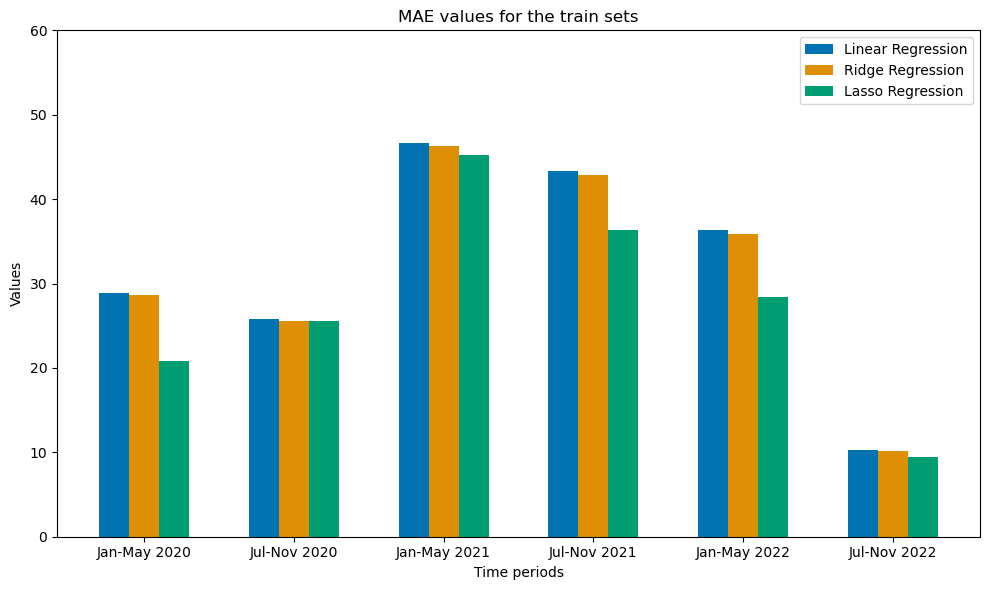

In [ ]:
# Data
categories = ['Jan-May 2020', 'Jul-Nov 2020', 'Jan-May 2021', 'Jul-Nov 2021', 'Jan-May 2022', 'Jul-Nov 2022']
values1 = [28.931, 25.790, 46.631, 43.325, 36.308, 10.331]  # First set of values for each category
values2 = [28.640, 25.574, 46.289, 42.815, 35.882, 10.177]  # Second set of values for each category
values3 = [20.860, 25.502, 45.199, 36.373, 28.401, 9.402]  # Third set of values for each category
print (sum(values1)/6)
print (sum(values2)/6)
print (sum(values3)/6)


# Number of categories
N = len(categories)
ind = np.arange(N)  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(ind - width, values1, width, label='Linear Regression')
bar2 = ax.bar(ind, values2, width, label='Ridge Regression')
bar3 = ax.bar(ind + width, values3, width, label='Lasso Regression')

# Adding labels, title, and legend
ax.set_xlabel('Time periods')
ax.set_ylabel('Values')
ax.set_title('MAE values for the train sets')
ax.set_ylim(0, 60)
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


36.702
36.38316666666666
29.820000000000004


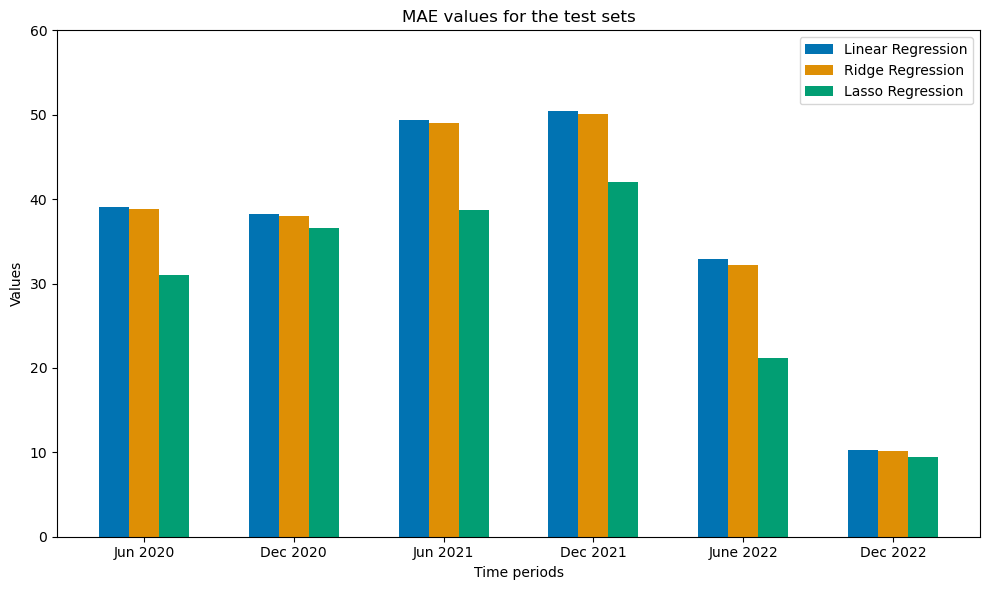

In [ ]:
# Data
categories = ['Jun 2020', 'Dec 2020', 'Jun 2021', 'Dec 2021', 'June 2022', 'Dec 2022']
values1 = [39.011, 38.250, 49.321, 50.481, 32.869, 10.280]  # First set of values for each category
values2 = [38.789, 38.059, 49.018, 50.037, 32.208, 10.188]  # Second set of values for each category
values3 = [31.059, 36.576, 38.671, 42.055, 21.157, 9.402]  # Third set of values for each category
print (sum(values1)/6)
print (sum(values2)/6)
print (sum(values3)/6)


# Number of categories
N = len(categories)
ind = np.arange(N)  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(ind - width, values1, width, label='Linear Regression')
bar2 = ax.bar(ind, values2, width, label='Ridge Regression')
bar3 = ax.bar(ind + width, values3, width, label='Lasso Regression')

# Adding labels, title, and legend
ax.set_xlabel('Time periods')
ax.set_ylabel('Values')
ax.set_title('MAE values for the test sets')
ax.set_ylim(0, 60)
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


#### 2.2 Random Forest (Sevi)

##### 2.2.1 Regular Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
scaling_factor = 0.8
mse_list=[]
r2_list=[]
feature_importances_list = []
fig, axs = plt.subplots(len(splits), 1, figsize=(20, 5*len(splits)))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)*scaling_factor

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]


    axs[i].plot(sorted_dates, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()

    importances = model.feature_importances_
    feature_importances_list.append(importances)
    feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })
    top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)

    # Print the summary of the model for the current split
    print(f"Summary for Split {i + 1}:")
    print(f"Mean Squared Error for Split {i + 1}: {mse}")
    print(f"R^2 Score for Split {i + 1}: {r2}")
    print("Top 5 Important Features:")
    print(top_5_features)
    print("----------------------------------------")



plt.tight_layout()
plt.savefig("../output/Models/ForestSeverin.png")
print("Overall Mean Squared Error:", np.mean(mse_list))
print("Overall R^2 Score:", np.mean(r2_list))

mean_importances = np.mean(feature_importances_list, axis=0)
overall_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})
top_10_features_overall = overall_feature_importances.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Important Features Overall:")
print(top_10_features_overall)

#### Model Interpretation

1) **Mean Squared Error (MSE):**
   - The MSE values range from **733.43 to 33375.94**, with an overall mean of **12513.14**.
   - Lower MSE values (e.g., 733.43 in Split 6) indicate closer predictions to true values.

2) **R² Score:**
   - The R² values range from **-0.107 to 0.748**, with an overall mean of **0.438**.
   - Higher R² scores (e.g., 0.748 in Split 1) indicate better explanation of variance by the model.

3) **Feature Importance:**
   - The most important features across all splits include **new_cases_smoothed**, **total_cases**, and **new_cases**. Other notable features are **new_cases_per_million**, **new_vaccinations**, and **male_smokers**.
   - Features related to case counts and vaccination rates consistently show high importance.

4) **Overall Interpretation:**
   - The mean MSE of 12513.14 indicates **large average squared differences** between predicted and actual values.
   - The overall R² score of 0.438 suggests the model **explains only 43.8% of the variance** in the data, indicating a moderate fit to the data.


##### 2.2.2 HP Tuned Model

- Commented out due to excessively long run-time

- This process typically results in lower Mean Squared Error (MSE) and higher R-squared (R²) scores compared to using default hyperparameters. 

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred

        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]


    axs[i].plot(sorted_dates, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()

    importances = best_model.feature_importances_
    feature_importances_list.append(importances)
    feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })
    top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)

    # Print the summary of the model for the current split
    print(f"Summary for Split {i + 1}:")
    print(f"Mean Squared Error for Split {i + 1}: {mse}")
    print(f"R^2 Score for Split {i + 1}: {r2}")
    print("Top 5 Important Features:")
    print(top_5_features)
    print("----------------------------------------")
    print("Best parameters found: ", grid_search.best_params_)


plt.tight_layout()
plt.savefig("../output/Models/ForestSeverin.png")
print("Overall Mean Squared Error:", np.mean(mse_list))
print("Overall R^2 Score:", np.mean(r2_list))

mean_importances = np.mean(feature_importances_list, axis=0)
overall_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})
top_10_features_overall = overall_feature_importances.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Important Features Overall:")
print(top_10_features_overall)
"""

#### 2.3 Support Vector Regression (Nico)

To implement the support vector regression we first need to find the best possible parameters for the function. In the following code we tried to find the best possible parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
"""
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

# Initialize the SVR model
svr = SVR()

# Initialize Grid Search
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit the Grid Search to the data
grid_search_svr.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found: ", best_params_svr)
"""

Then the Support Vector Regression was used on the Training and Test Splits. MSE and R2 were used to evaluate the models performance. As well as a graphic representation of the predicted values and the actual values.
Because of an immense run time the function above could not be used. Instead a few parameters were entered manually and the ones with the best results were used for the implementation.

In [ ]:
predictions_svr = []
mse_scores_svr = []
mae_scores_svr = []
r2_scores_svr = []

fig, axs = plt.subplots(6, 1, figsize=(15, 20))

# Train and evaluate SVR model for each split
for i, ((X_train_scaled, y_train), X_test_scaled, y_test) in enumerate(zip(scaled_train_sets, scaled_test_sets, true_y_values)):
    # Initialize and train the SVR model
    svr = SVR(kernel='rbf', C=100.0, epsilon=0.1)
    svr.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred_svr = svr.predict(X_test_scaled)
    predictions_svr.append(y_pred_svr)
    
    # Evaluate the model
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    mae_svr = mean_absolute_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    mse_scores_svr.append(mse_svr)
    mae_scores_svr.append(mae_svr)
    r2_scores_svr.append(r2_svr)
    
    # Print results for the current split
    print(f"Split {i+1} - Mean Squared Error: {mse_svr}")
    print(f"Split {i+1} - Mean Absolute Error: {mae_svr}")
    print(f"Split {i+1} - R2 Score: {r2_svr}")
    print("Predictions vs Actual values:")
    print(pd.DataFrame({'Predicted': y_pred_svr, 'Actual': y_test.values}).head())
    print("------------------------------------------------------------------------------------------------------------------------")

    # Summed values per date
    predicted_sums_svr = {}
    true_sums = {}
    for date, pred, true in zip(test_data['date'], y_pred_svr, y_test):
        if date in predicted_sums_svr:
            predicted_sums_svr[date] += pred
        else:
            predicted_sums_svr[date] = pred

        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    
    # Sort dates for plotting
    sorted_dates_svr = sorted(predicted_sums_svr.keys())
    summed_predicted_values_svr = [predicted_sums_svr[date] for date in sorted_dates_svr]
    summed_true_values = [true_sums[date] for date in sorted_dates_svr]

    # Plotting
    axs[i].plot(sorted_dates_svr, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates_svr, summed_predicted_values_svr, marker='x', linestyle='--', label='Summed Predicted Values')
    axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2_svr,3)}, MSE: {round(mse_svr,3)}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()

plt.tight_layout()
plt.savefig("../output/Models/SupportVectorRegression.png")

# Summarize overall performance
print("Overall Mean Squared Error across all splits:", np.mean(mse_scores_svr))
print("Overall Mean Absolute Error across all splits:", np.mean(mae_scores_svr))
print("Overall R2 score across all splits:", np.mean(r2_scores_svr))

An MSE of 12786.191687816201 suggests that, on average, the squared errors are relatively high, indicating that there might be significant discrepancies between the predicted and actual values.

An MAE of 26.95207964508874 suggests that, on average, the model's predictions are off by approximately 27. This gives a more interpretable sense of the prediction errors in the same units as the target variable. 

An R² score of 0.4081813930347116 means that the model explains about 41% of the variance in the target variable. This suggests a moderate fit, as it explains some but not all of the variability.

Conclusion:
This means that the model has only a moderate level of explanatory power. It captures some of the variance in the data but leaves a significant portion unexplained.
Error Metrics: Both MSE and MAE values suggest that there are considerable prediction errors. The relatively high MAE (around 27) indicates that the model's predictions deviate significantly from actual values on average.

#### 2.4 ARIMAX (Leon)

I am using the ARIMAX model. It does not need to be scaled before using it.

In [ ]:
#The feature 'date' has to stay, it is needed in a time series prediciton, the others can be chosen and one can try out different ones
#do not take 'new_deaths' or any other death variables, these are the labels
features = ["date", "new_cases", "total_vaccinations", "stringency_index"]

#All data:
data_grouped = data_clean.groupby('date').sum().reset_index()

#Data for whole continents:
all_continents = data_clean["continent"].unique()
your_continent = "North America"
continent_iso_codes = data_clean[data_clean['continent'] == your_continent]['iso_code'].unique()
continent_data = data_clean[data_clean['iso_code'].isin(continent_iso_codes)]
continent_data_grouped = continent_data.groupby('date').sum().reset_index()

#Data for a country:
your_country = "AUT"
specific_country = data_clean[data_clean['iso_code'] == your_country]

def arimax_model(splits, data, features):
    fig, axs = plt.subplots(6, 1, figsize=(20, 15))
    for i, (train_dates, test_dates) in enumerate(splits):
        # Filter the continent data based on the train and test dates
        train_data = data[data['date'].isin(train_dates)]
        test_data = data[data['date'].isin(test_dates)]

        # Splitting into label and features
        X_train = train_data[features].set_index('date')
        X_test = test_data[features].set_index('date')
        y_train = train_data[['date', 'new_deaths']].set_index('date')
        y_test = test_data[['date', 'new_deaths']].set_index('date')

        #Scaled features perform worse, thats why I leave it out
        """
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        """

        model = auto_arima(y=y_train, X=X_train, m=7, start_p=0, start_q=0, max_p=2, max_d=2, max_q=2)
        y_pred = pd.Series(model.predict(n_periods=30, X=X_test))
        y_pred.index = y_test.index

        axs[i].plot(test_data["date"], y_test, marker='o', linestyle='-', label='True Values')
        axs[i].plot(test_data["date"], y_pred, marker='x', linestyle='--', label='Predicted Values')
        axs[i].set_title(f"Split {i + 1}: True vs Predicted Values")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("New deaths")
        axs[i].legend()

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        # Print the summary of the model for the current split
        print(f"Summary for Split {i + 1}:")
        print(f"Mean Squared Error for Split {i + 1}: {mse}")
        print(f"R-squared for Split {i + 1}: {r2}")
        print("----------------------------------------")
        
    plt.tight_layout()


Trying the model for the whole dataset:

In [ ]:
arimax_model(splits, data_grouped, features)

Trying the model for one continent only:

In [ ]:
arimax_model(splits, continent_data_grouped, features)

Trying the model for a country only:

In [ ]:
arimax_model(splits, specific_country, features)

### 3 Model Evaluation